### DEM Super Resolution Upscaling

The openly available SuperResolution model is from this paper: 2023 _"A Global-Information-Constrained Deep Learning Network for Digital Elevation Model Super-Resolution"_ (https://www.mdpi.com/2072-4292/15/2/305)


### ノートブックの概要: DEM超解像度アップスケーリング

このノートブックは、デジタル標高モデル（DEM）の解像度を向上させるために、超解像度敵対的生成ネットワーク（SRGAN）を実装しています。このアーキテクチャは、「グローバル情報制約付き深層学習ネットワークによるデジタル標高モデル超解像度」と題された研究論文に基づいています。

以下の主要な段階をカバーしています。

1.  **環境設定とライブラリのインポート:** 必要なライブラリをインポートし、データアクセス用にGoogle Driveをマウントします。
2.  **モデルアーキテクチャの定義:** ジェネレータ、ディスクリミネータ、特徴抽出器、およびカスタムRMSE損失関数を定義します。
3.  **データ準備:** サンプルのDEMを読み込み、高解像度（HR）タイルに分割し、対応する低解像度（LR）タイルを生成し、トレーニング用のPyTorchデータセットを作成します。
4.  **モデルトレーニング:** ハイパーパラメータ、最適化アルゴリズムを設定し、SRGANモデルのトレーニングループを実行します。
5.  **モデルテストと再構築:** トレーニング済みモデルを読み込み、新しいLRタイルに適用してHR予測を生成し、その後、完全な超解像度DEMを再構築します。

### 各セクションの詳細な要約:

#### **1. セットアップとライブラリ (`n_UF5pPbuThk` - `DswtP0uiynWp` セル)**

*   **`google.colab.drive`**: Google Driveをマウントするために使用され、ノートブックがユーザーのDriveに保存されたファイルにアクセスできるようになります。
*   **`skimage`, `os`, `numpy`, `math`, `itertools`, `sys`, `torchvision`, `torch`, `torch.nn`, `torch.nn.functional`, `glob`, `random`, `PIL.Image`, `time`, `datetime`, `torch.utils.tensorboard`, `tifffile`**: これらのライブラリは、画像処理、数値演算、深層学習モデルの定義とトレーニング（PyTorch）、ファイルシステム操作、ロギングなど、さまざまなタスクのためにインポートされます。

#### **2. モデルアーキテクチャ (`u1kvDx5PyaEI` - `qiLjiK735uIP` セル)**

*   **`FeatureExtractor`**: 画像から特徴を抽出するニューラルネットワークです。VGG19モデルに基づいており、トレーニング中に知覚損失を計算するために使用されます。
*   **`ResidualBlock`**: ジェネレータの基本的な構成要素であり、深いネットワークのトレーニングの安定性とパフォーマンスを向上させるように設計されています。
*   **`GeneratorResNet`**: コアとなる超解像度モデルです。低解像度（LR）DEMを入力として受け取り、高解像度（HR）DEMを出力することを目指します。残差ブロックとピクセルシャッフル層をアップサンプリングに利用します。
*   **`C` (Discriminator Network)**: 真のHR DEMと生成されたHR DEMを区別しようとする畳み込みニューラルネットワークです。これは敵対的トレーニングプロセスにとって重要です。
*   **`RMSELoss`**: 予測されたDEM値と真のDEM値の差を測定するために使用される、ルート平均二乗誤差損失関数のカスタム実装です。
*   **`ImageDataset`**: DEM画像を読み込み、正規化を実行し、トレーニングのためにLRとHRのペアに分割する役割を担うカスタムPyTorch `Dataset`クラスです。

#### **3. データ準備 (`8mzjS_5yww_3` - `-G86sXMTcDuQ` セル)**

*   **読み込みとタイリング**: `rasterio` を使用して、元の高解像度画像 `center_tile.tif` が読み込まれます。この大きな画像は、その後、小さな64x64ピクセルのタイル (`images_tiles`) に分割されます。
*   **HRタイルの保存**: 64x64の高解像度タイルは、Google Driveに `hr_*.tif` ファイルとして保存されます。
*   **LRタイルの生成**: 各HRタイルに対して、対応するLRタイルが次のように作成されます。
    *   最近傍補間 (`gdal` および `numpy`) を使用して、HRタイルを半分の解像度（32x32）にダウンサンプリングします。
    *   順序0（最近傍）補間 (`scipy.ndimage.zoom`) を使用して、32x32のLRタイルを64x64にアップサンプリングします。これにより、ピクセル化されたLRバージョンが作成されます。
    *   元のHRタイルと生成されたLRタイルを水平方向に連結して、`ImageDataset`で利用される結合された `m*.tif` 画像を形成します。

#### **4. モデルトレーニング (`cMDkVeXPkg5x` - `5p0yVS5XkMpy` セル)**

*   **ハイパーパラメータ**: `n_epochs`、`batch_size`、`learning_rate`、`hr_height`、`hr_width`のような主要なトレーニングパラメータが定義されます。
*   **モデル初期化**: `GeneratorResNet`、`C` (ディスクリミネータ)、`FeatureExtractor`モデルが初期化されます。CUDAが利用可能な場合、GPUに移動されます。
*   **損失関数**: `RMSELoss`は敵対的損失と直接的なピクセル単位の比較の両方に使用され、`torch.nn.L1Loss`はコンテンツ損失（`FeatureExtractor`を介した知覚損失）に使用されます。
*   **オプティマイザ**: ジェネレータとディスクリミネータの両方にAdamオプティマイザが設定されます。
*   **トレーニングループ**: コードはエポックとバッチを反復します。
    *   **ジェネレータトレーニング**: LR入力からHR画像を生成します。ジェネレータの損失は、コンテンツ損失（生成された画像と実際のHR画像からの特徴間のL1損失）、敵対的損失（ディスクリミネータから）、および生成されたHR画像と実際のHR画像間の直接的なRMSE損失で構成されます。
    *   **ディスクリミネータトレーニング**: 実際のHR画像と偽のHR画像を区別するようにトレーニングされます。その損失は、実際のHR画像を「有効」として正しく分類する能力と、生成されたHR画像を「偽」として分類する能力の組み合わせです。
*   **ロギングとチェックポイント**: トレーニングの進行状況（G損失）が出力され、中間的に生成された画像が`sample_interval`で保存されます。モデルの重みは`checkpoint_interval`エポックで保存されます。

#### **5. 損失の可視化 (`nNQ8sQ9c0xTX` - `cTuS1KlqiQH2` セル)**

*   トレーニング後、記録されたジェネレータの損失値（`loss_list`）がトレーニングエポックに対してプロットされ、学習曲線が視覚化されます。

#### **6. モデルテストと再構築 (`TC__6Vcjt5Hs` - `Wcz-PgdWRzpB` セル)**

*   **モデルの再インポートと読み込み**: 必要なライブラリが再インポートされ、トレーニング済みの`GeneratorResNet`モデル（具体的には`generator_240.pth`チェックポイント）が読み込まれます。
*   **テストデータ準備**: テスト用の`center_tile.tif`が読み込まれ、トレーニングデータと同様に64x64タイルに分割されます。重要なステップは、すべてのジェネレータへの入力タイルが64x64であることを保証するために、正確に64x64でないエッジタイルを隣接するタイルからのデータでパディングすることです。このパディング情報は後で元に戻すために保存されます。
*   **超解像度推論**: 準備された各LRテストタイルは、読み込まれたジェネレータモデルを通過します。モデルは超解像度HRタイルを出力します。生成された出力は、元の標高値範囲に戻すために非正規化ステップを受けます。
*   **タイル再構築**: 生成されたHRタイルが収集されます。準備中に適用されたパディングは削除されます。最後に、これらの処理されたHRタイルは、元のグリッドレイアウトで結合され、完全な超解像度DEM画像が再構築されます。最終的に再構築された画像は`gene_test_imge.tif`として保存されます。

In [18]:
import rasterio
import numpy as np

# ご自身のトレーニング用オリジナルDEMのパスを指定してください
fp_your_dem = r"/home/s1300211/Documents/datasets/training/NAC_DTM_A17_1500.tif" # このパスをご自身のトレーニング用DEMのパスに置き換えてください

with rasterio.open(fp_your_dem) as src:
    your_dem_data = src.read(1) # 最初のバンドを読み込む

# 欠損値（NaN）を除外して最小値と最大値を計算する
# もしDEMに欠損値がないと確信できる場合は、np.nanmin/np.nanmaxの代わりにnp.min/np.maxを使用できます。
min_val = np.nanmin(your_dem_data)
max_val = np.nanmax(your_dem_data)

print(f"ご自身のDEMデータの最小値: {min_val}")
print(f"ご自身のDEMデータの最大値: {max_val}")


ご自身のDEMデータの最小値: -1310.47265625
ご自身のDEMデータの最大値: -1176.5936279296875


In [19]:
# Google Colab環境でのマウント（ローカル環境では不要）
# from google.colab import drive
# drive.mount("/content/drive")

In [20]:
import subprocess
import sys

# 必要なパッケージをインストール
packages = ['torch', 'torchvision', 'torchaudio', 'scikit-image', 'scipy', 'rasterio', 'tifffile']
print("Installing required packages...")
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
        print(f"✓ {package} installed successfully")
    except:
        print(f"⚠ {package} installation attempted")
print("Done!")

Installing required packages...
✓ torch installed successfully
✓ torch installed successfully
✓ torchvision installed successfully
✓ torchvision installed successfully
✓ torchaudio installed successfully
✓ torchaudio installed successfully
✓ scikit-image installed successfully
✓ scikit-image installed successfully
✓ scipy installed successfully
✓ scipy installed successfully
✓ rasterio installed successfully
✓ rasterio installed successfully
✓ tifffile installed successfully
Done!
✓ tifffile installed successfully
Done!


In [21]:
# ================================
# パス設定（ローカル環境用）
# ================================
# Google Colabではなくローカル環境で実行する場合は、以下のパスを変更してください

import os

# 基本ディレクトリ
BASE_DIR = "/home/s1300211/Documents"  # あなたの作業ディレクトリに変更してください
DATASET_DIR = os.path.join(BASE_DIR, "DEM-Super-Resolution", "dataset")  # データセットディレクトリ
MODEL_DIR = os.path.join(BASE_DIR, "DEM-Super-Resolution", "models")  # モデル保存ディレクトリ
CHECKPOINT_DIR = os.path.join(BASE_DIR, "DEM-Super-Resolution", "checkpoint")  # チェックポイント保存ディレクトリ

# ディレクトリが存在しない場合は作成
for dir_path in [DATASET_DIR, MODEL_DIR, CHECKPOINT_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# DEM入出力ファイルパス（ご自身のDEMファイルパスに変更してください）
DEM_TRAIN_PATH = os.path.join(BASE_DIR, "datasets", "your_training_dem.tif")  # トレーニング用DEM
DEM_TEST_PATH = os.path.join(BASE_DIR, "datasets", "your_test_dem.tif")  # テスト用DEM

print(f"Dataset directory: {DATASET_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")


Dataset directory: /home/s1300211/Documents/DEM-Super-Resolution/dataset
Model directory: /home/s1300211/Documents/DEM-Super-Resolution/models
Checkpoint directory: /home/s1300211/Documents/DEM-Super-Resolution/checkpoint


In [22]:
# import libraries
import argparse
from skimage import io
import os
import numpy as np
import math
import itertools
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import glob
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import time
import datetime
from torch.utils.tensorboard import SummaryWriter
import tifffile as tiff

# Train model


In [23]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(
            *list(vgg19_model.features.children())[:18]
        )

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU()
        )

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
        )

        # Upsampling layers
        upsampling = []
        # 修改代码 只扩大er倍
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                # 尺度变换4*4 选用基于插值bicubic的Upsample替代PixelShuffle
                # nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=9, stride=2, padding=4), nn.Tanh()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class C(nn.Module):
    def __init__(self, input_shape):
        super(C, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2**4), int(in_width / 2**4)
        self.output_shape = (1, patch_h, patch_w)

        def c_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(
                nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1)
            )
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(
                nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1)
            )
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(c_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, truth):
        return torch.sqrt(torch.mean((pred - truth) ** 2))
        torch.square((pred - truth) ** 2)


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [54]:
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, root, hr_shape, global_min=None, global_max=None):
        hr_height, hr_width = hr_shape
        self.global_min = global_min
        self.global_max = global_max
        self.lr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.files = sorted(glob.glob(root + "/m*.*"))

    def __getitem__(self, index):
        img = io.imread(self.files[index % len(self.files)])
        
        # Use global_min and global_max if provided, otherwise compute from image
        if self.global_min is not None and self.global_max is not None:
            min_value = self.global_min
            max_value = self.global_max
        else:
            min_value = np.min(img)
            max_value = np.max(img)
        
        # Normalize to [-1, 1] range
        abs_min_value = np.abs(min_value)
        shifted_img = img + abs_min_value
        img_ts = self.lr_transform(shifted_img)
        
        # Normalize based on global or local min/max
        range_val = (max_value + abs_min_value)
        if range_val > 0:
            img_ts = (img_ts - 0) / (range_val / 2) - 1
        
        w = img_ts.shape[2] // 2
        img_lr = img_ts[:, :, w:]
        img_hr = img_ts[:, :, :w]
        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)


In [56]:
#! pip install rasterio

# Make train dataset


## Our original image


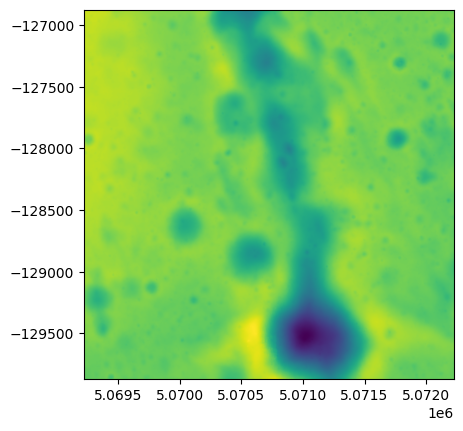

<Axes: >

In [57]:
import rasterio
from rasterio.plot import show

fp = r"/home/s1300211/Documents/datasets/training/NAC_DTM_A17_1500.tif"
img = rasterio.open(fp)
show(img)

In [58]:
img.width

1500

In [59]:
img.height

1500

In [60]:
img_hr = img.read()[0]

In [61]:
img_hr.shape

(1500, 1500)

In [62]:
# used for naormalization
min(img_hr.flatten())

-1310.4727

In [63]:
max(img_hr.flatten())

-1176.5936

## Split image to n 64\*64 images


In [64]:
M, N = 64, 64
images_tiles = [
    img_hr[x : x + M, y : y + N]
    for x in range(0, img_hr.shape[0], M)
    for y in range(0, img_hr.shape[1], N)
]

In [65]:
# we get 676 images
len(images_tiles)

576

In [66]:
# for i in images_tiles:
#   print(i.shape)

In [67]:
# save images
index = 0
for img in images_tiles:
    if img.shape == (64, 64):
        tiff.imwrite(DATASET_DIR + "/hr_" + str(index) + ".tif", img)
        index += 1

## Visualization of examples from High-resolution (HR) images


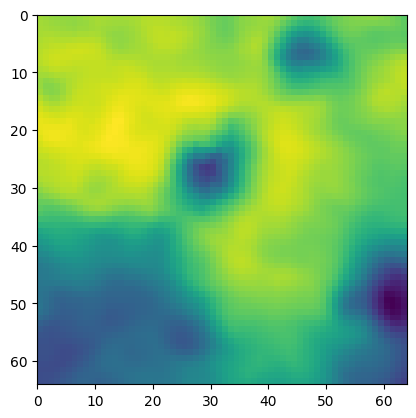

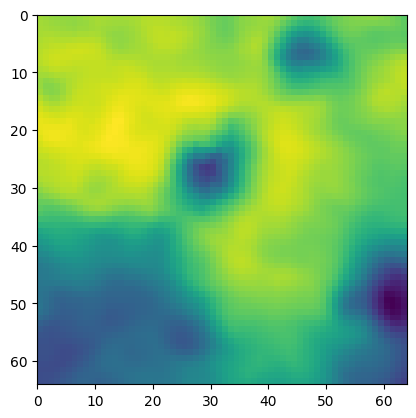

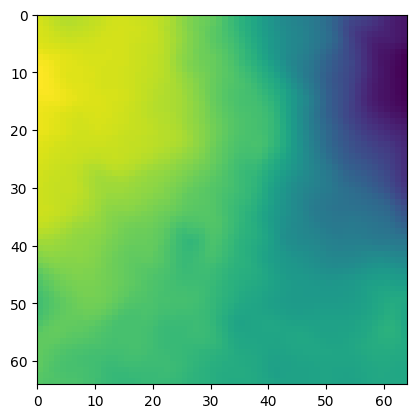

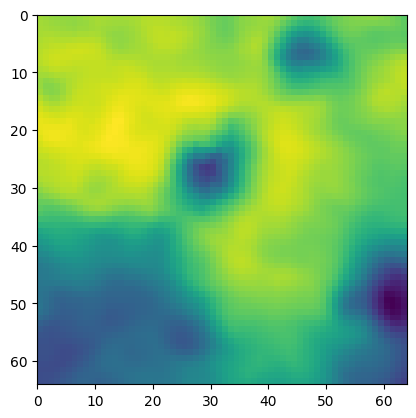

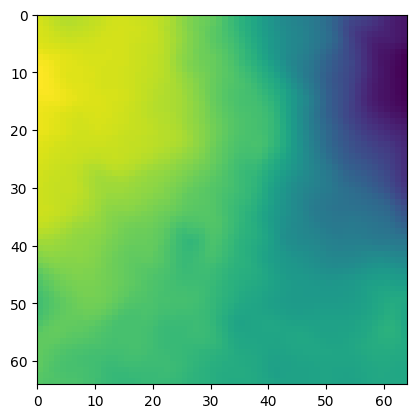

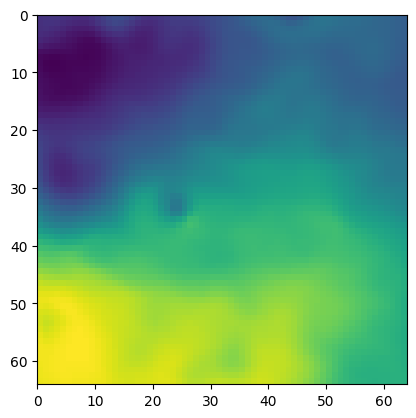

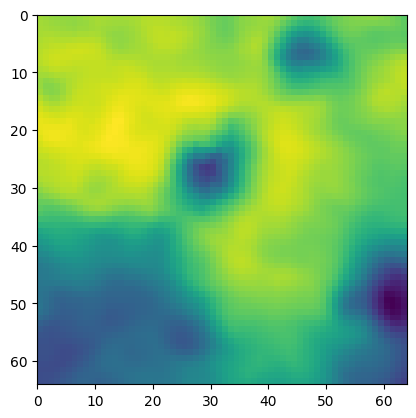

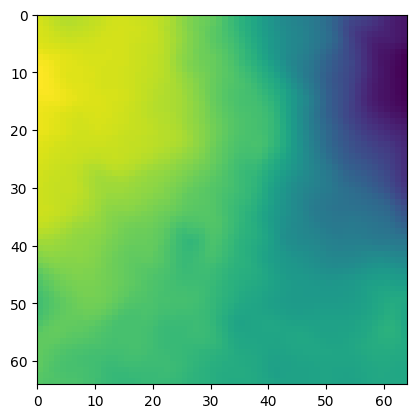

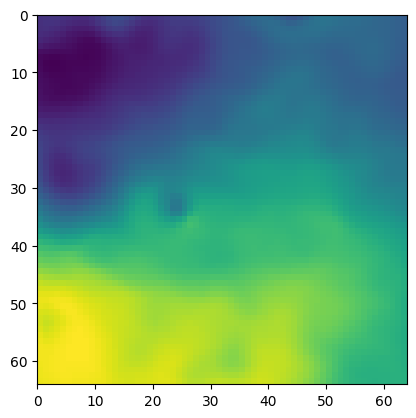

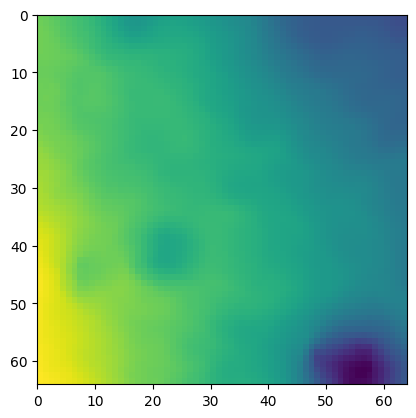

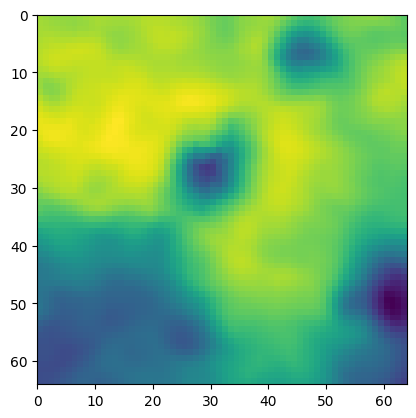

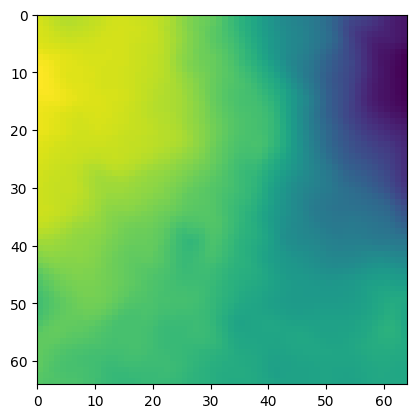

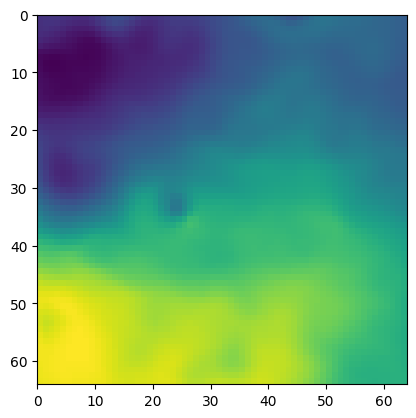

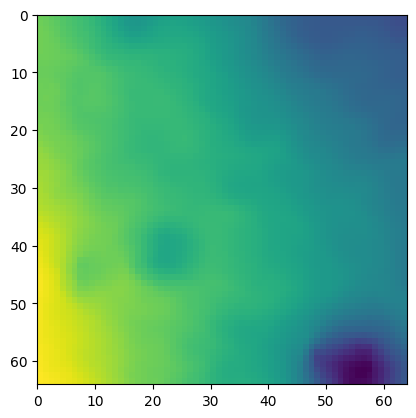

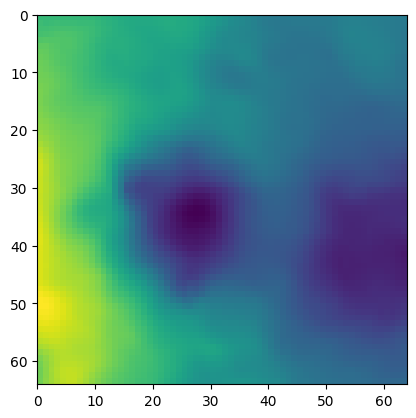

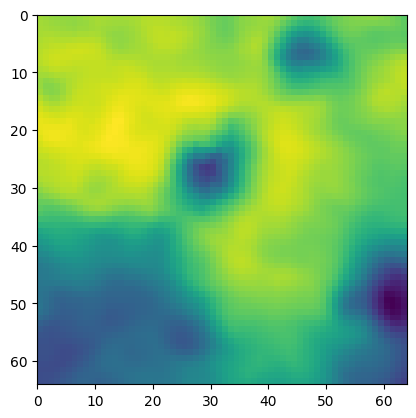

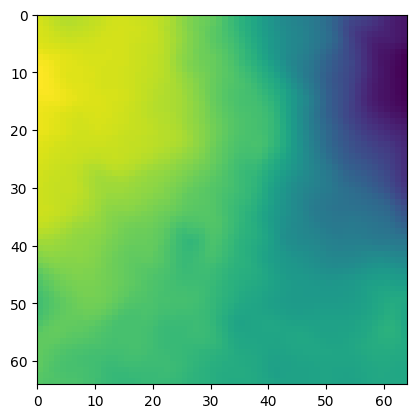

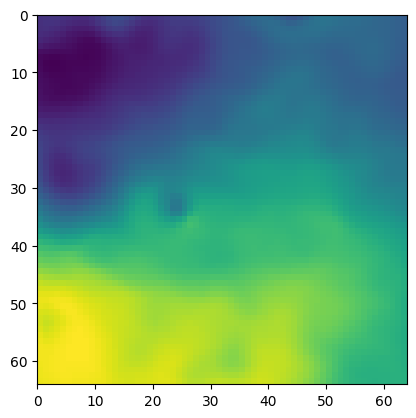

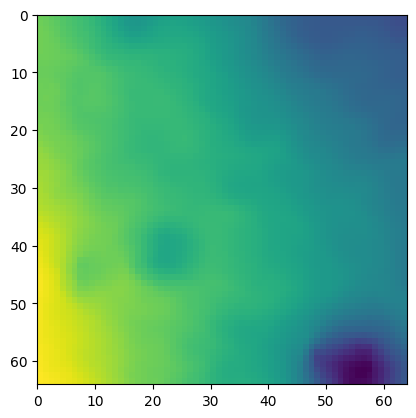

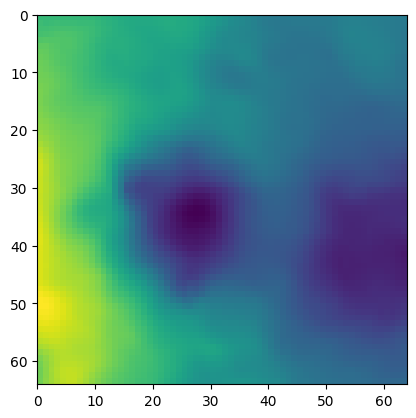

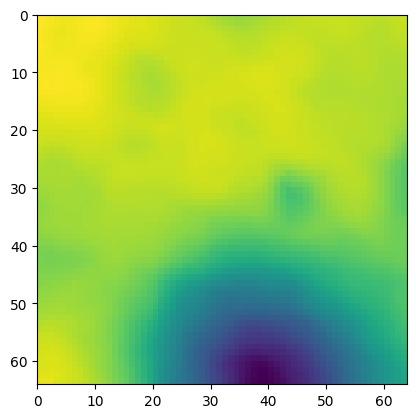

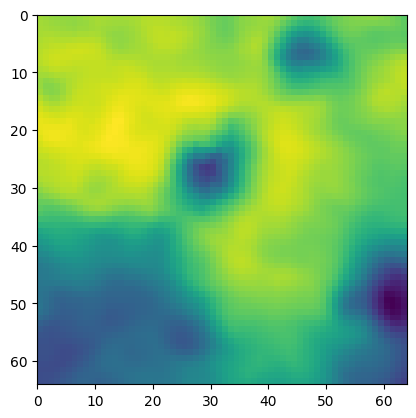

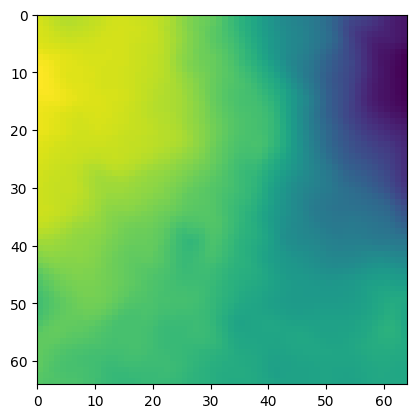

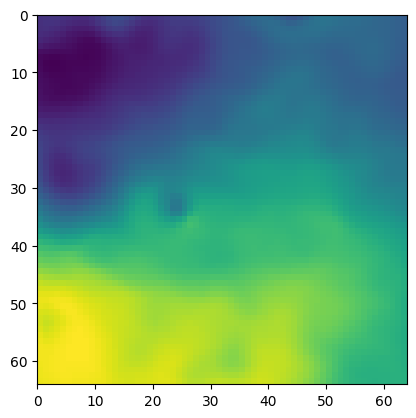

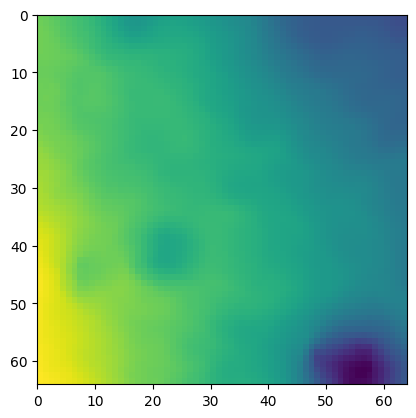

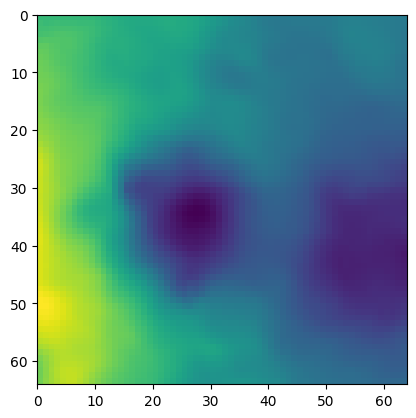

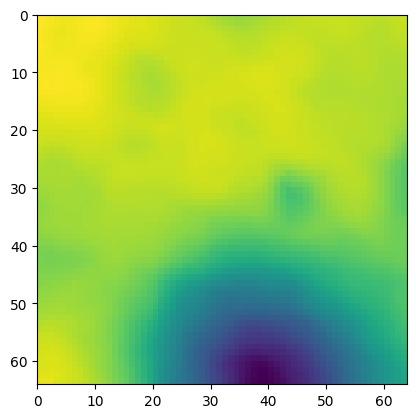

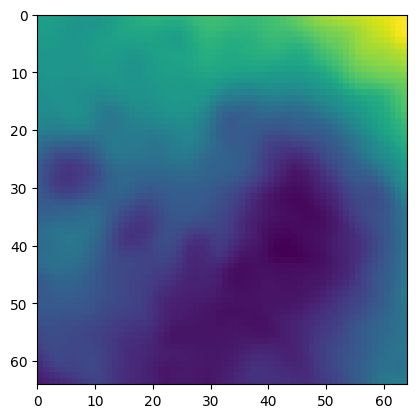

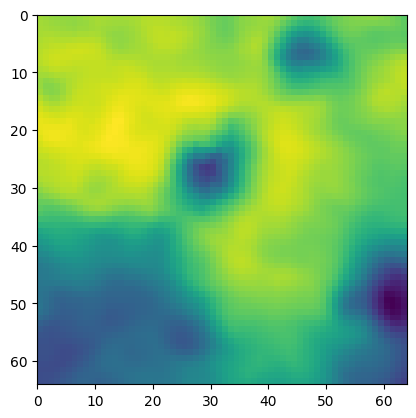

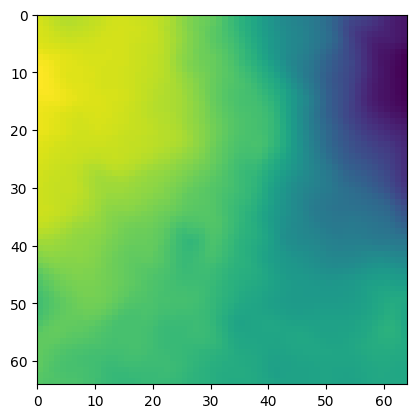

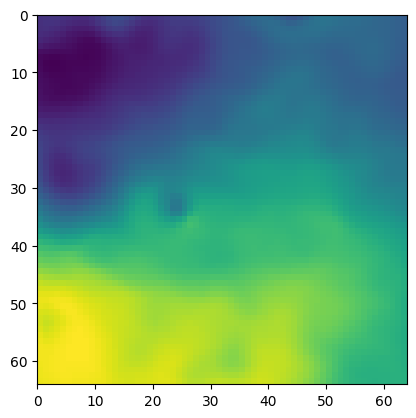

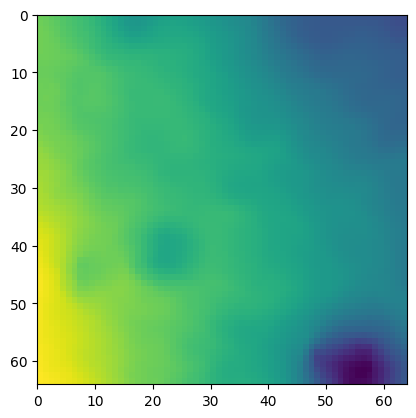

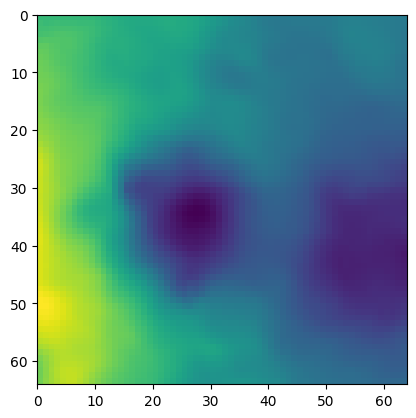

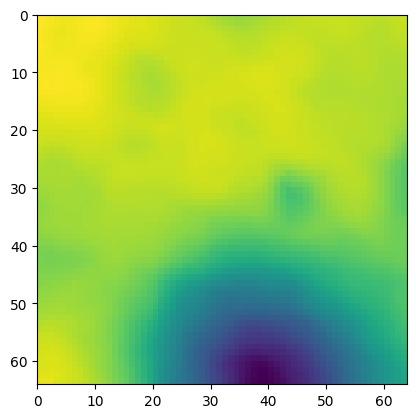

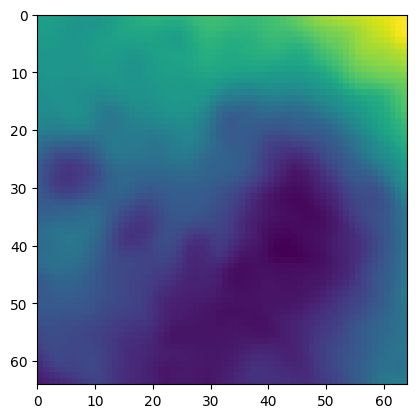

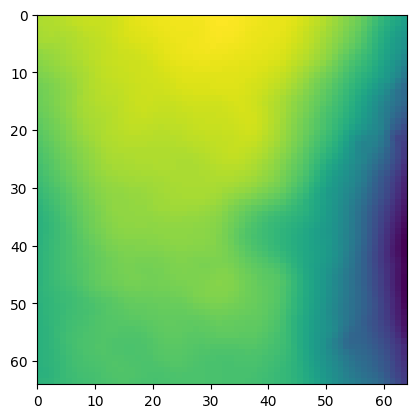

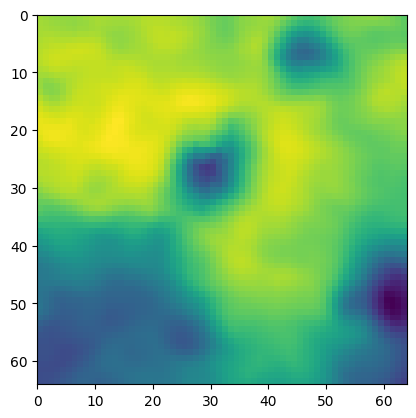

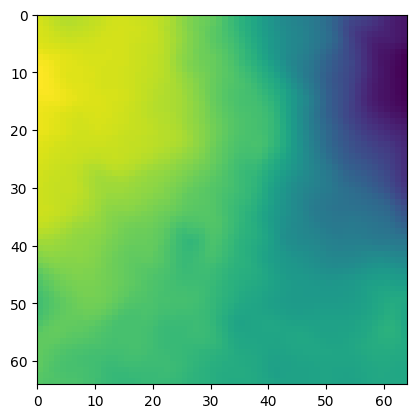

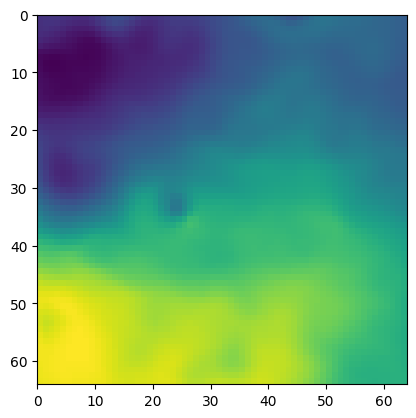

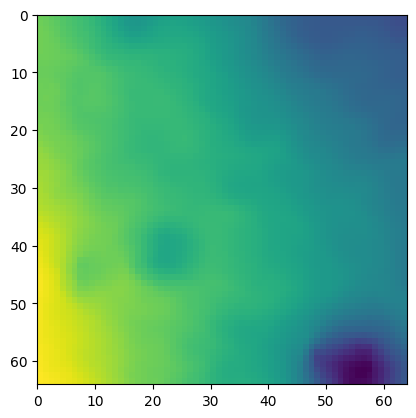

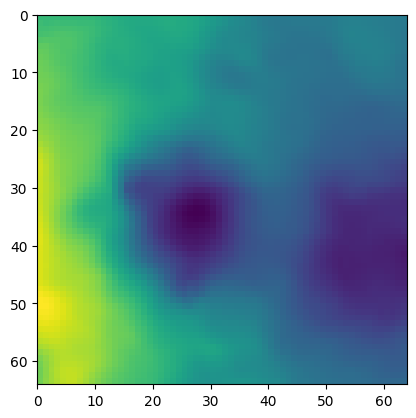

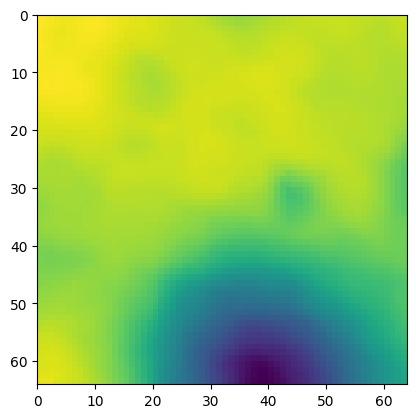

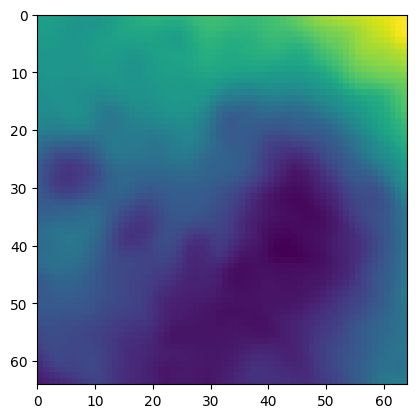

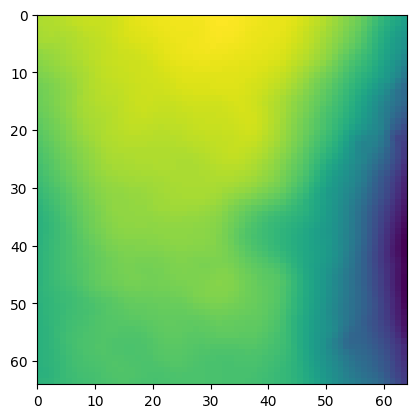

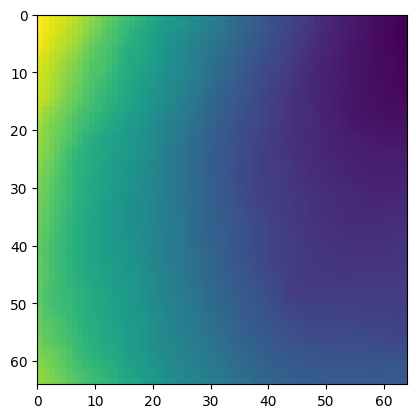

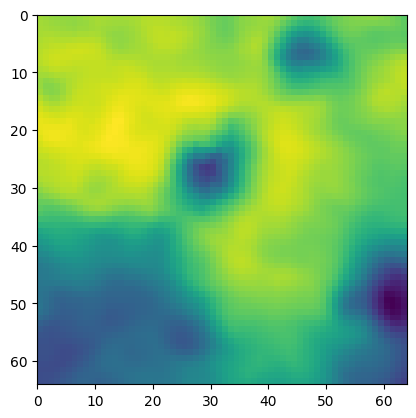

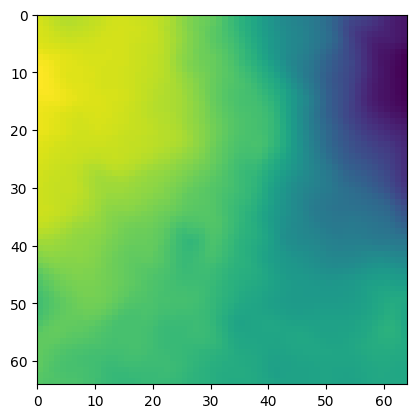

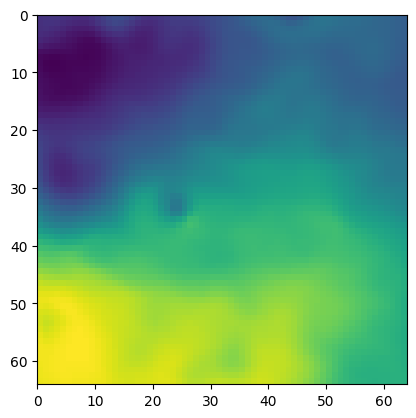

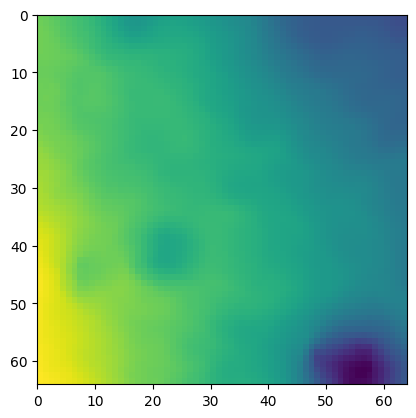

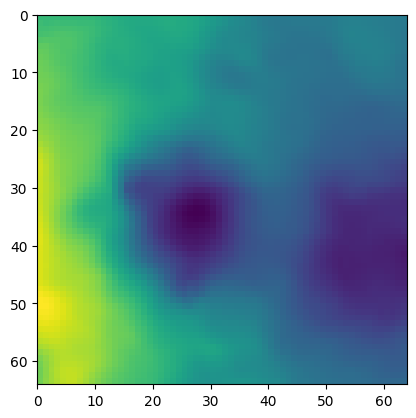

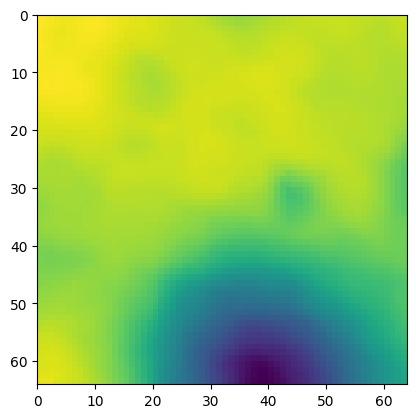

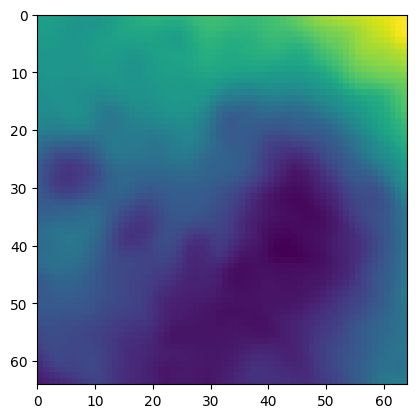

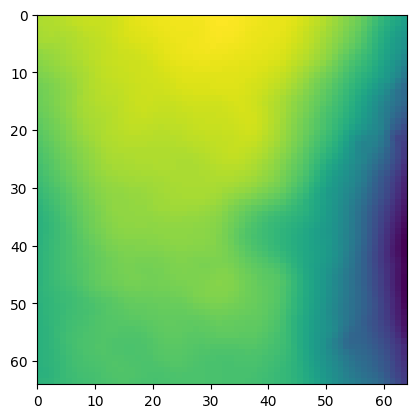

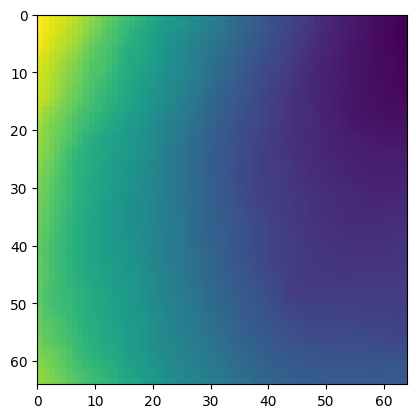

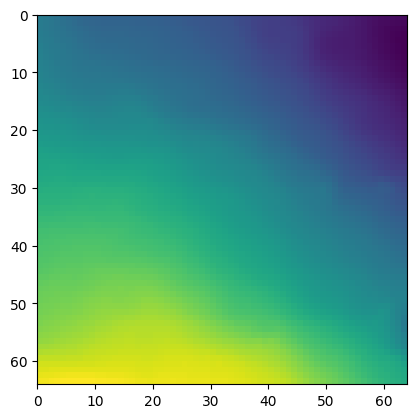

In [68]:
for index in range(10):
    fp = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/hr_" + str(index) + ".tif"
    img = rasterio.open(fp)
    show(img)

## Extract Low-resolution (LR) images from HR images


In [69]:
#!pip install -q condacolab
# import condacolab
# condacolab.install()
#!mamba install -q gdal=3.4.1
# from osgeo import gdal
# gdal.VersionInfo()

In [70]:
from scipy import ndimage
import rasterio
from rasterio.plot import show

In [71]:
# Count how many HR tiles were actually saved
num_hr_tiles = 0
for img in images_tiles:
    if img.shape == (64, 64):
        num_hr_tiles += 1

print(f"Processing {num_hr_tiles} HR tiles...")

for image_index in range(num_hr_tiles):
    # Use rasterio instead of GDAL
    hr_file_path = DATASET_DIR + "/hr_" + str(image_index) + ".tif"
    
    with rasterio.open(hr_file_path) as src:
        elevation_data = src.read(1)
    
    # Define the new resolution
    new_resolution = 0.5  # Example: half the resolution
    
    # Compute the new size
    original_height, original_width = elevation_data.shape
    new_height = int(original_height * new_resolution)
    new_width = int(original_width * new_resolution)
    
    # Rescale the image using nearest neighbor interpolation
    downscaled_data = np.zeros((new_height, new_width))
    for i in range(new_height):
        for j in range(new_width):
            # Calculate the corresponding pixel coordinates in the original image
            x = int(i / new_resolution)
            y = int(j / new_resolution)
            downscaled_data[i, j] = elevation_data[x, y]  # Assign the value from the nearest neighbor
    
    downsampled_dem = downscaled_data
    
    # Define the upsampling factor
    upsample_factor = 2  # Change this value as needed
    
    # Upsample the image using nearest neighbor interpolation (order=0)
    upsampled_dem = ndimage.zoom(downsampled_dem, upsample_factor, order=0)
    
    # Concatenate hr image with lr image horizontally
    image = np.concatenate((elevation_data, upsampled_dem), axis=1)
    tiff.imwrite(DATASET_DIR + "/m" + str(image_index) + ".tif", image)
    
    if (image_index + 1) % 10 == 0:
        print(f"  Processed {image_index + 1}/{num_hr_tiles} tiles")

Processing 529 HR tiles...
  Processed 10/529 tiles
  Processed 20/529 tiles
  Processed 30/529 tiles
  Processed 40/529 tiles
  Processed 50/529 tiles
  Processed 60/529 tiles
  Processed 70/529 tiles
  Processed 80/529 tiles
  Processed 90/529 tiles
  Processed 100/529 tiles
  Processed 110/529 tiles
  Processed 120/529 tiles
  Processed 130/529 tiles
  Processed 140/529 tiles
  Processed 150/529 tiles
  Processed 160/529 tiles
  Processed 170/529 tiles
  Processed 180/529 tiles
  Processed 190/529 tiles
  Processed 200/529 tiles
  Processed 210/529 tiles
  Processed 220/529 tiles
  Processed 230/529 tiles
  Processed 240/529 tiles
  Processed 250/529 tiles
  Processed 260/529 tiles
  Processed 270/529 tiles
  Processed 280/529 tiles
  Processed 290/529 tiles
  Processed 150/529 tiles
  Processed 160/529 tiles
  Processed 170/529 tiles
  Processed 180/529 tiles
  Processed 190/529 tiles
  Processed 200/529 tiles
  Processed 210/529 tiles
  Processed 220/529 tiles
  Processed 230/529 

## Plot examples from the dataset


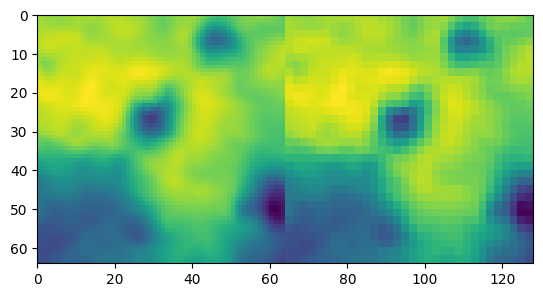

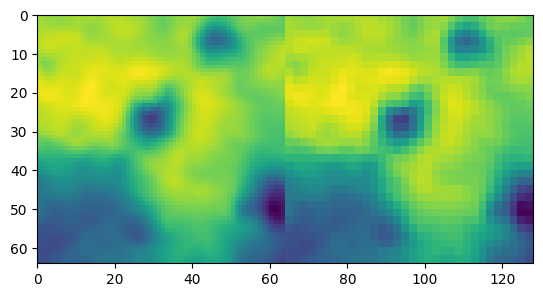

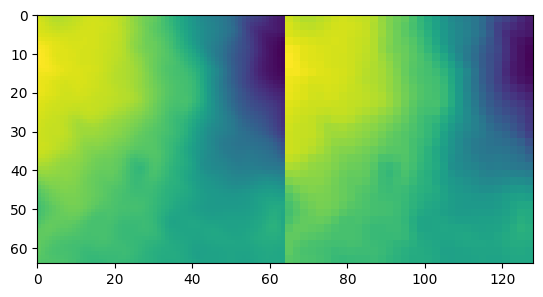

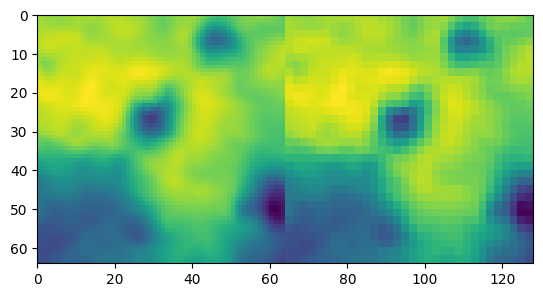

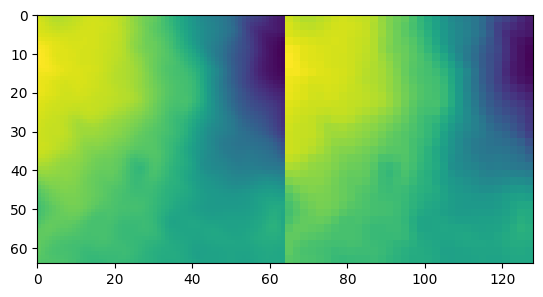

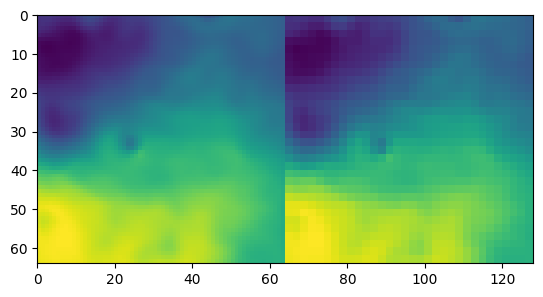

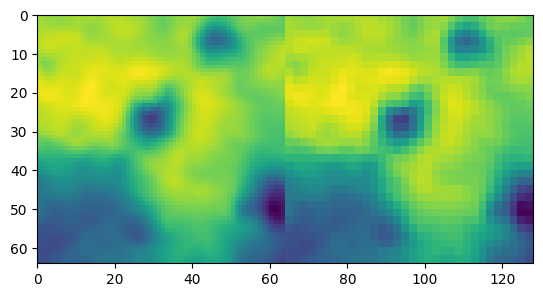

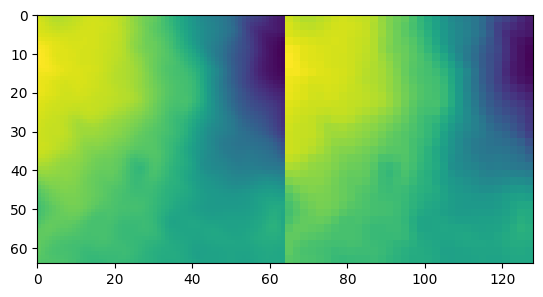

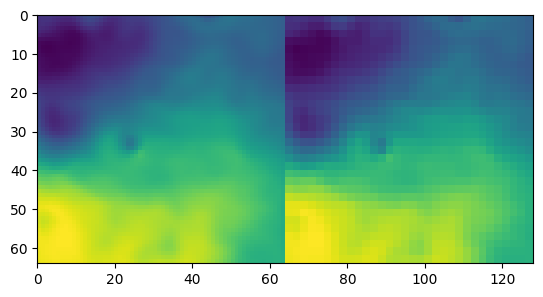

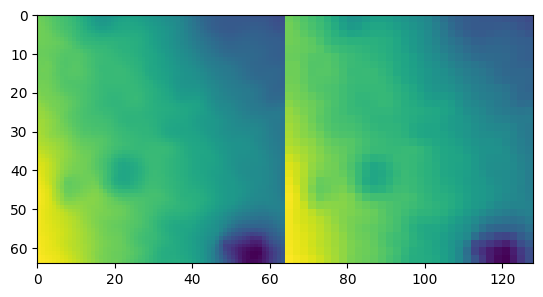

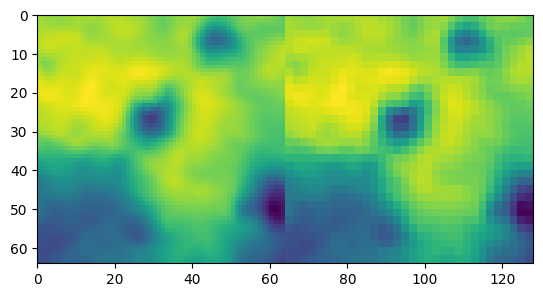

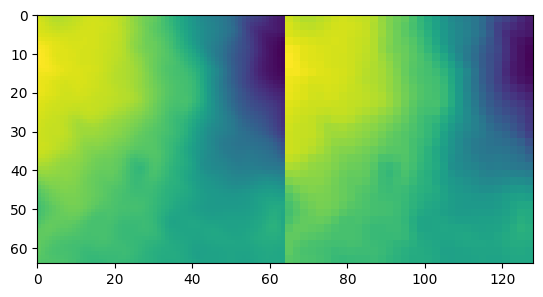

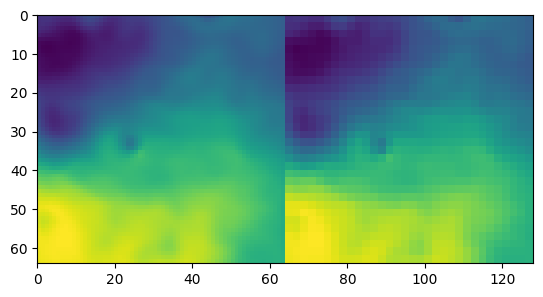

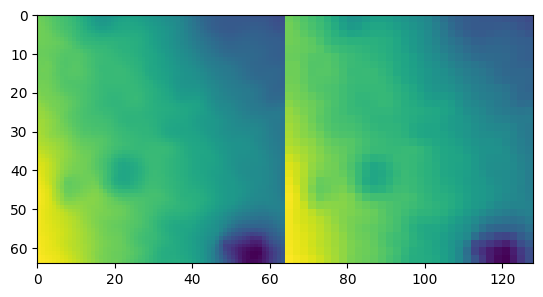

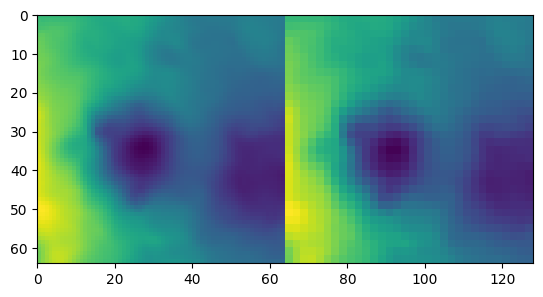

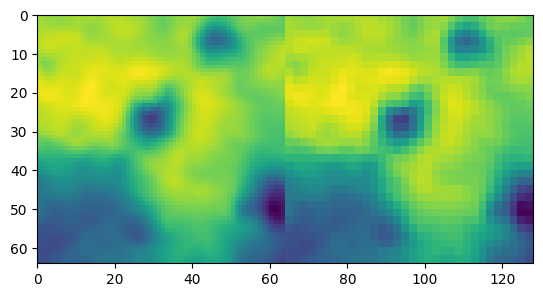

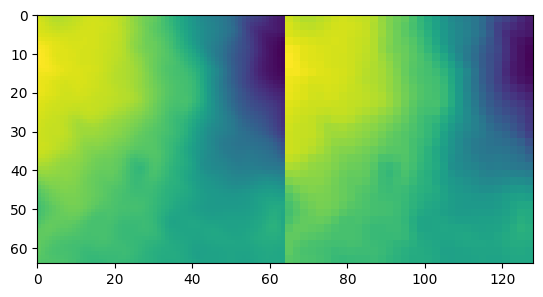

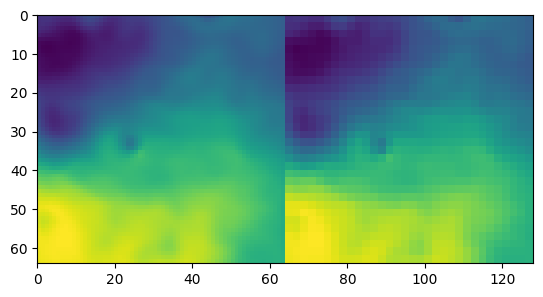

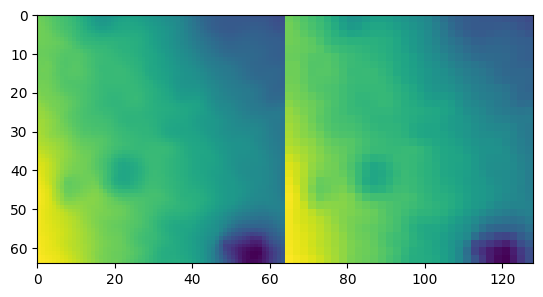

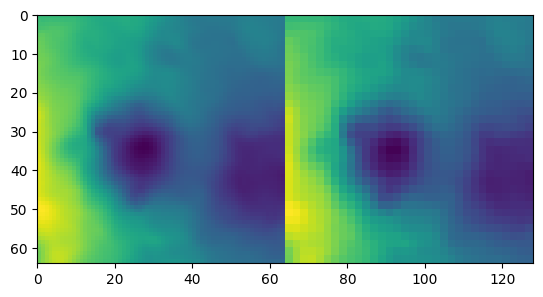

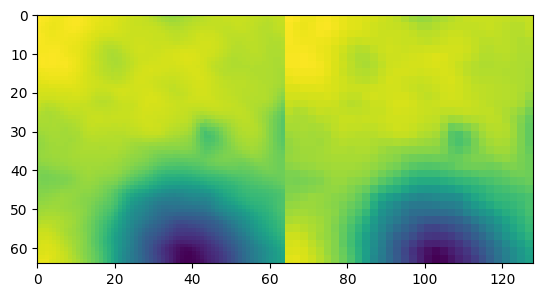

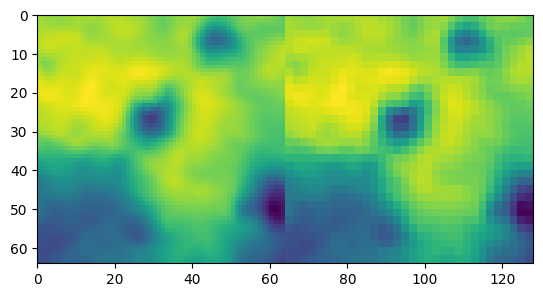

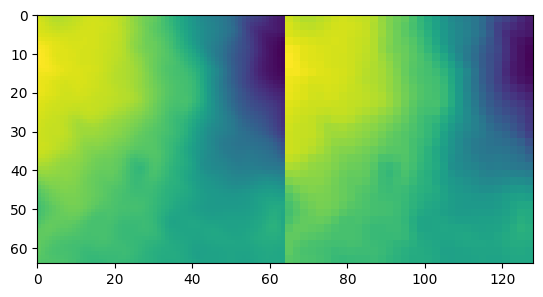

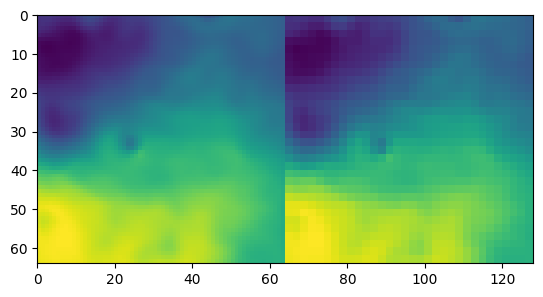

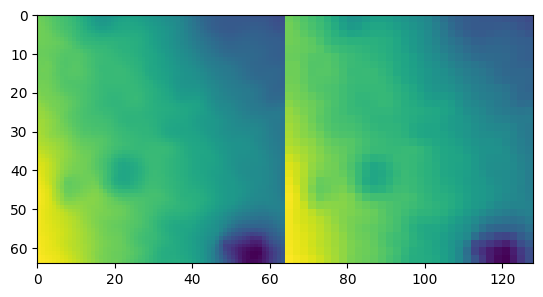

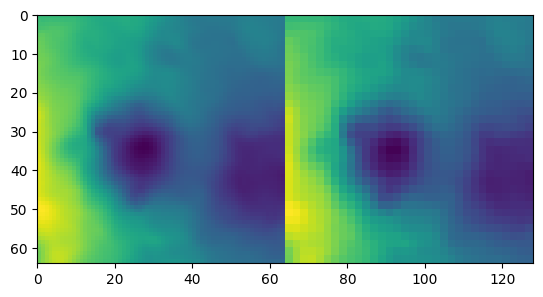

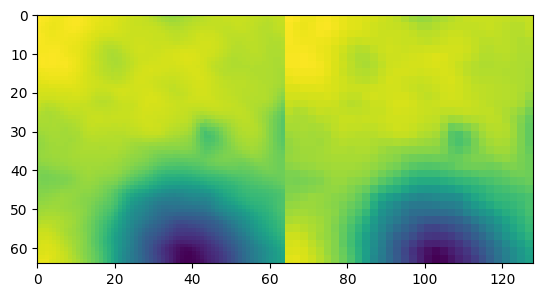

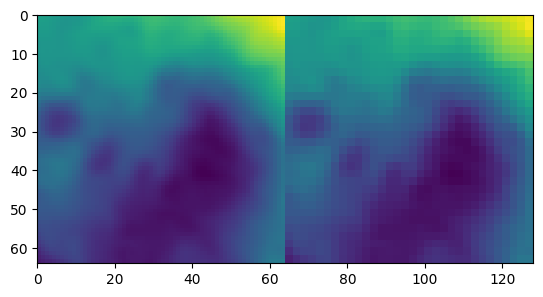

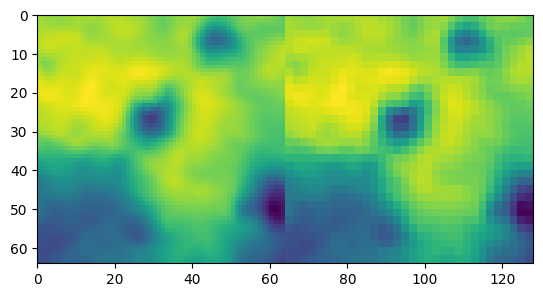

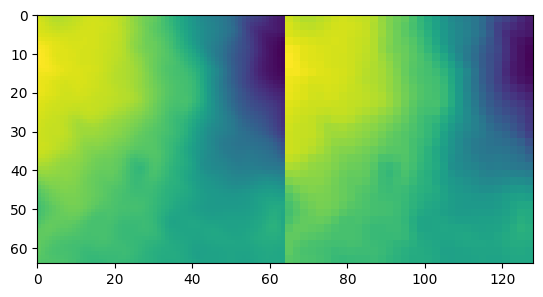

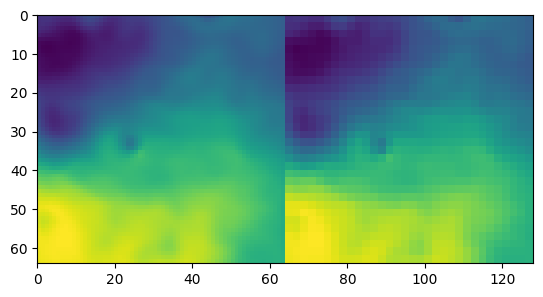

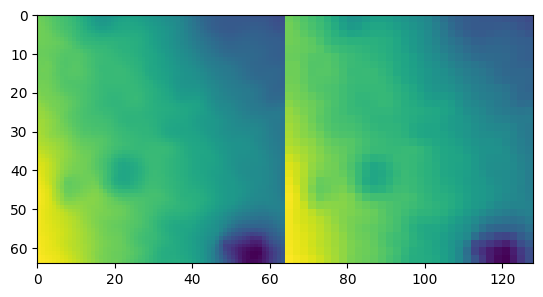

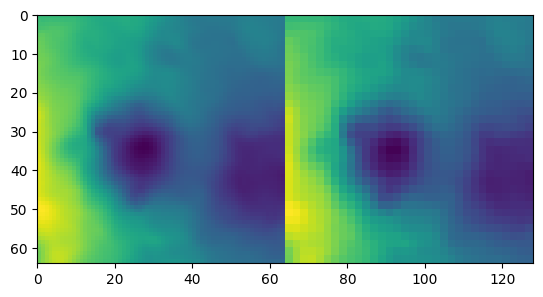

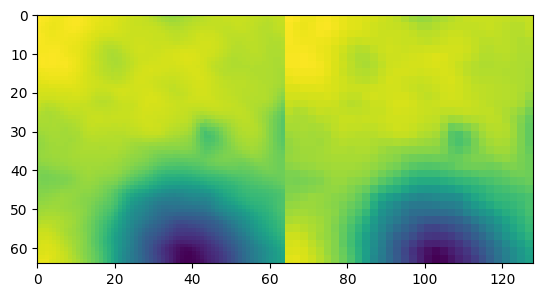

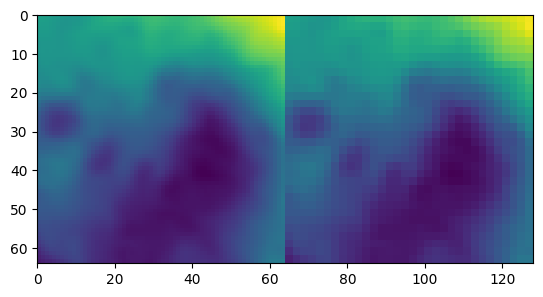

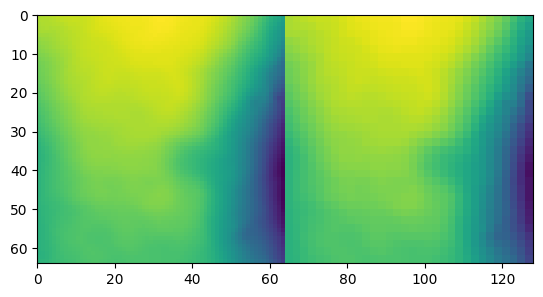

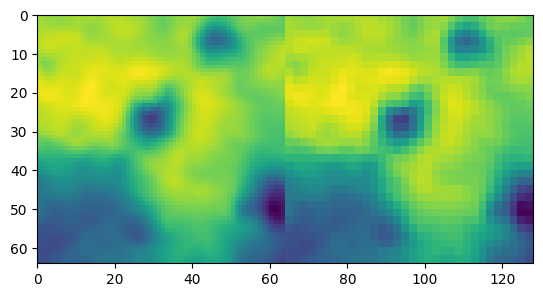

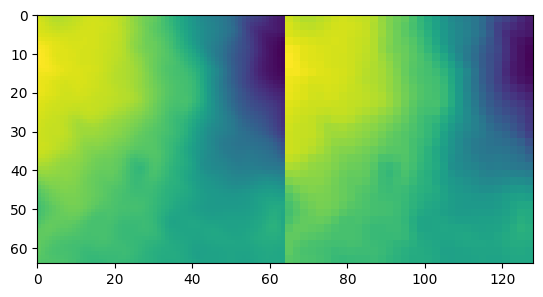

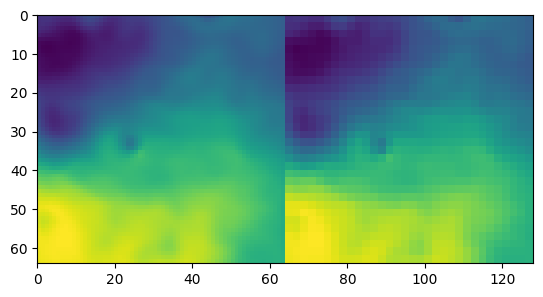

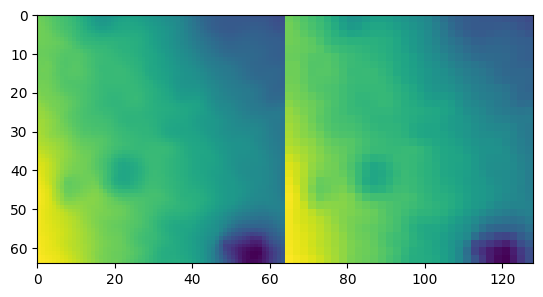

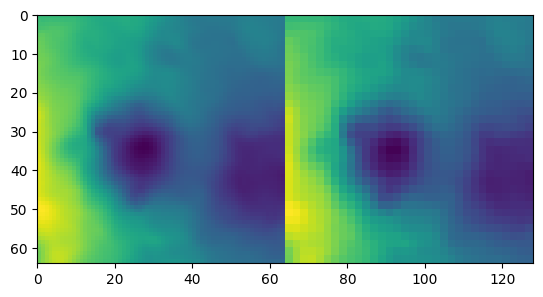

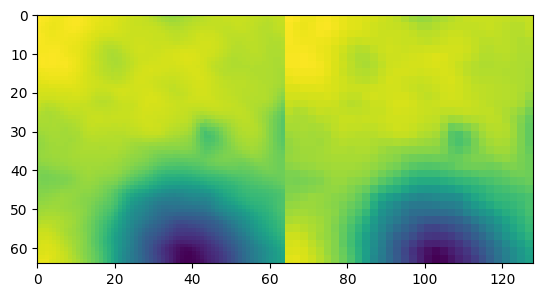

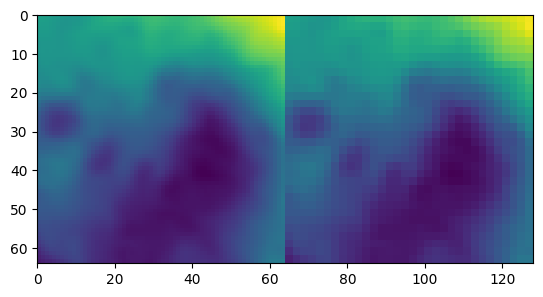

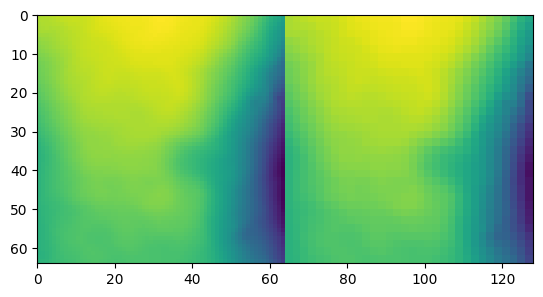

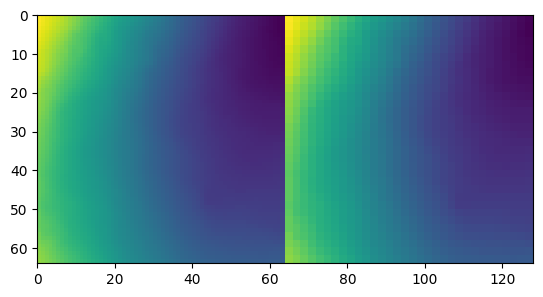

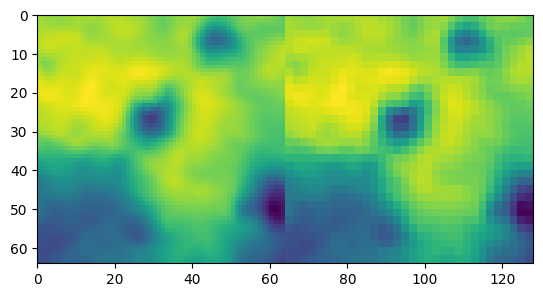

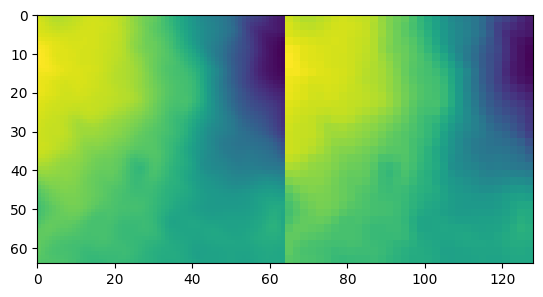

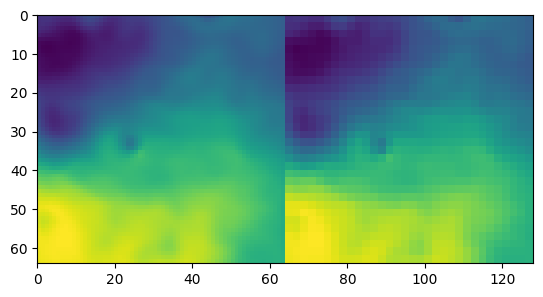

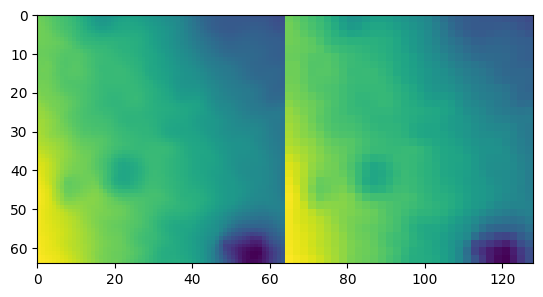

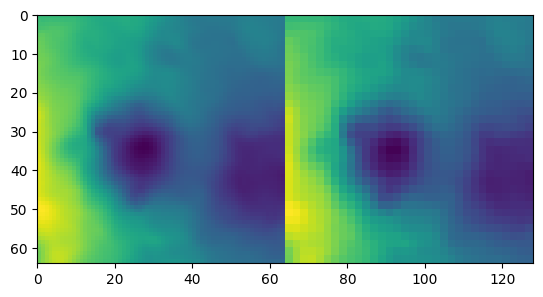

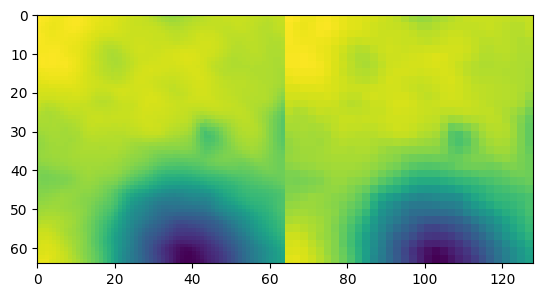

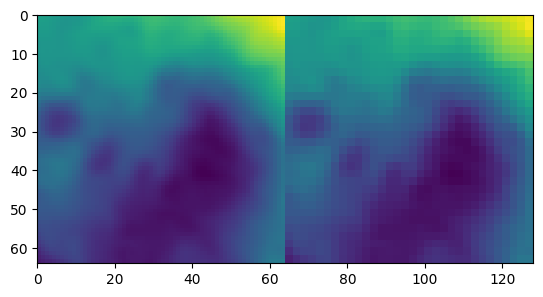

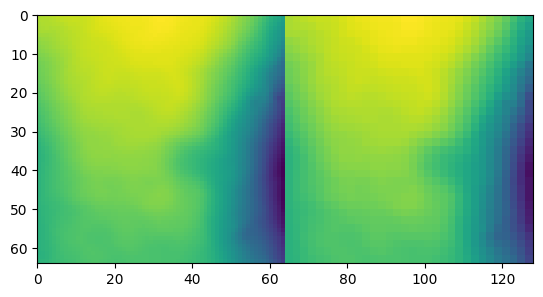

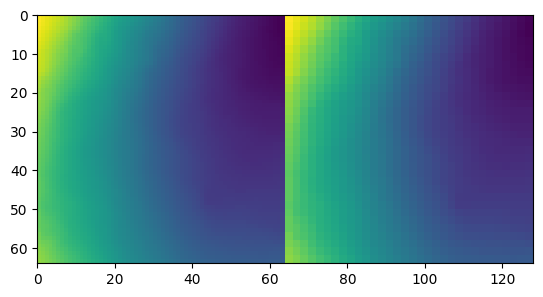

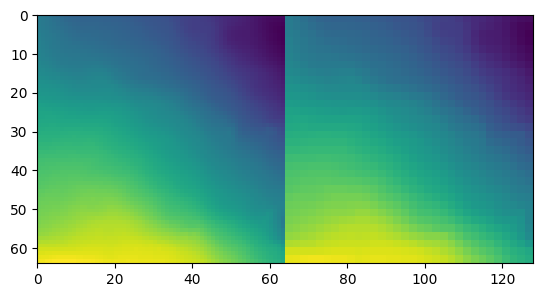

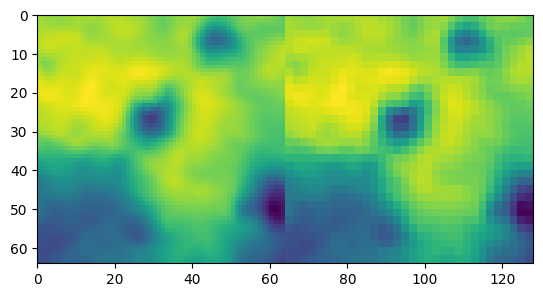

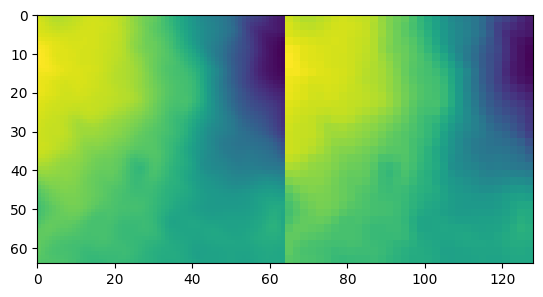

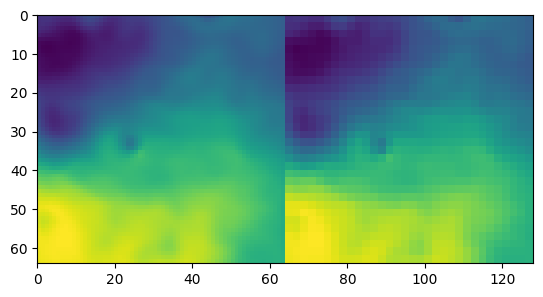

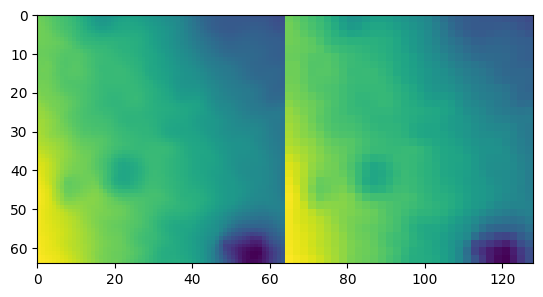

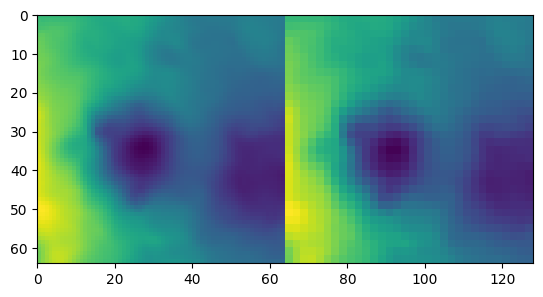

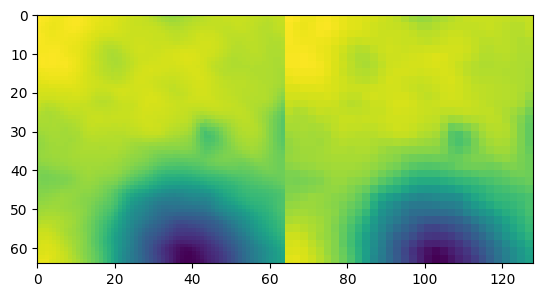

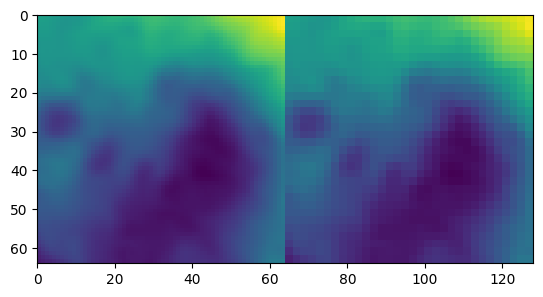

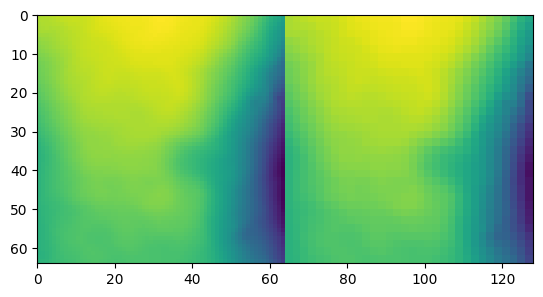

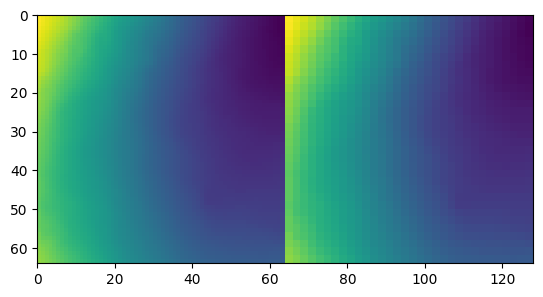

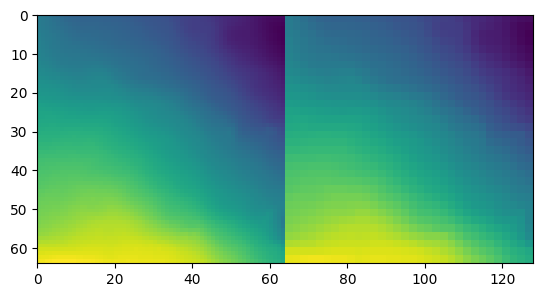

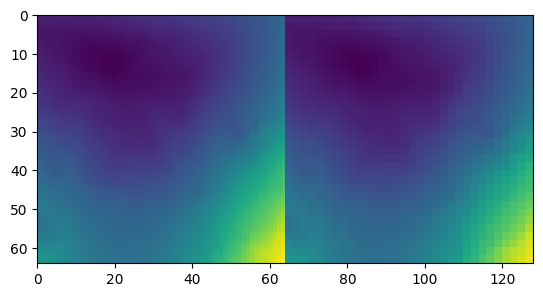

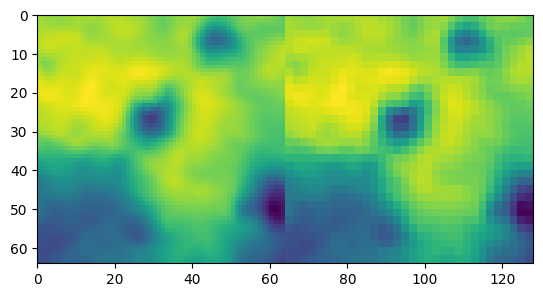

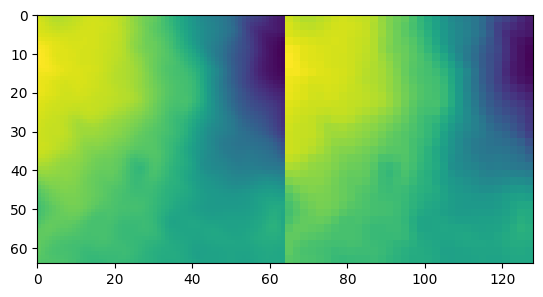

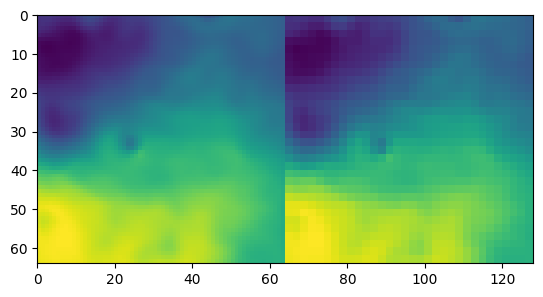

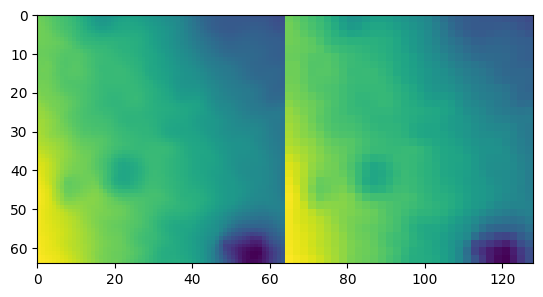

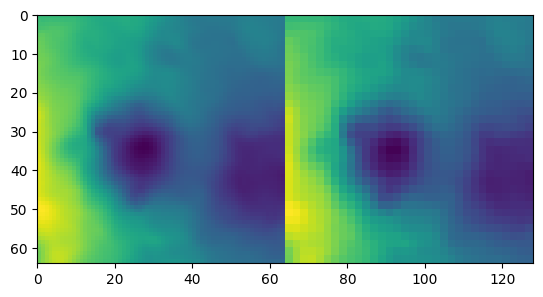

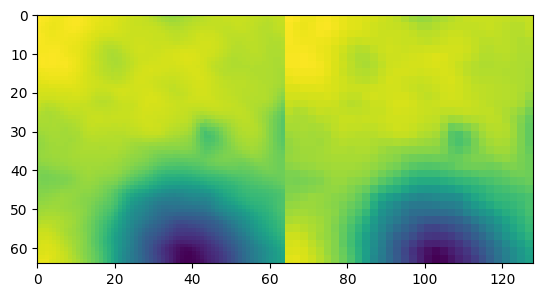

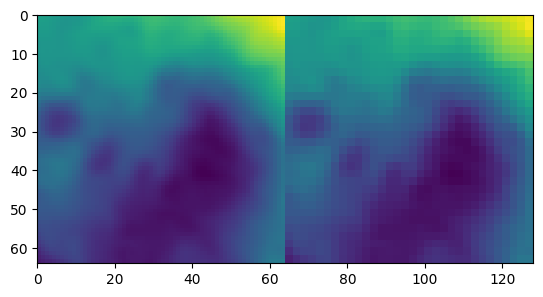

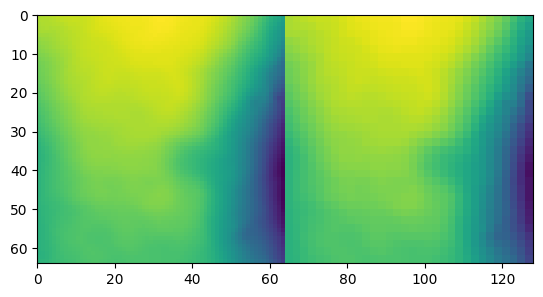

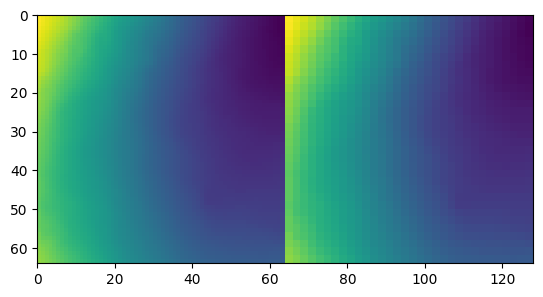

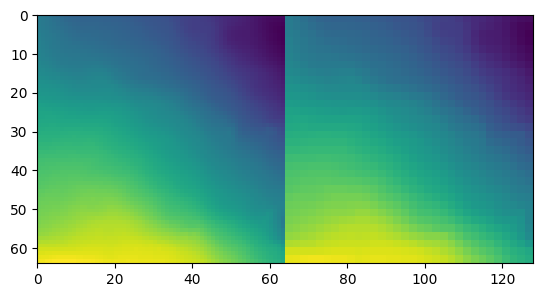

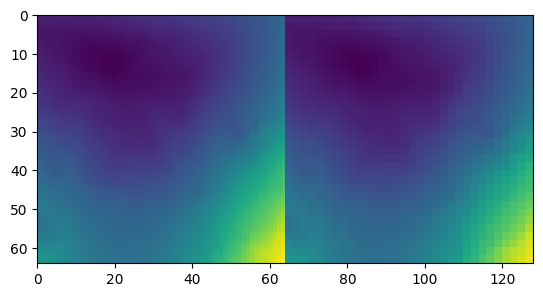

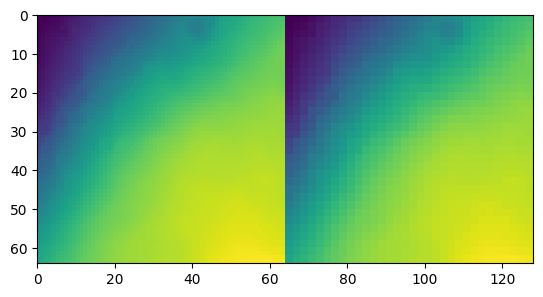

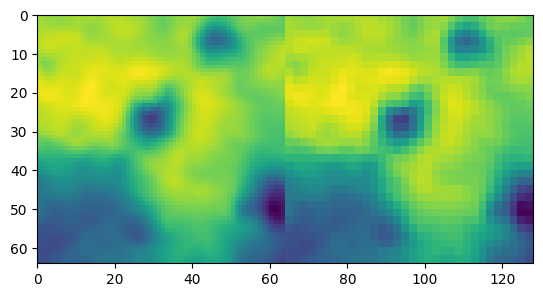

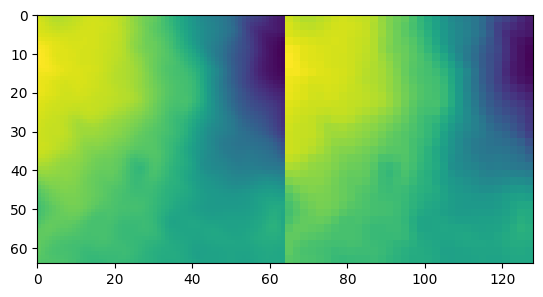

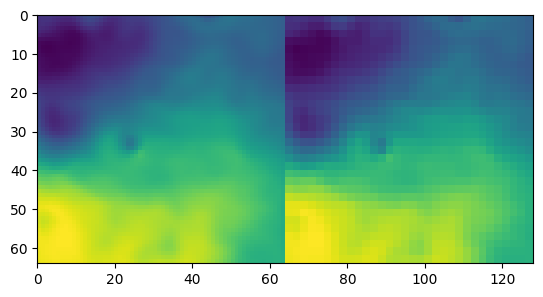

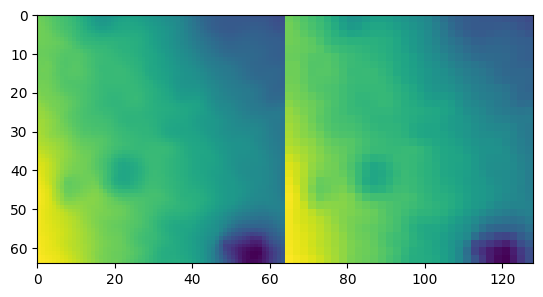

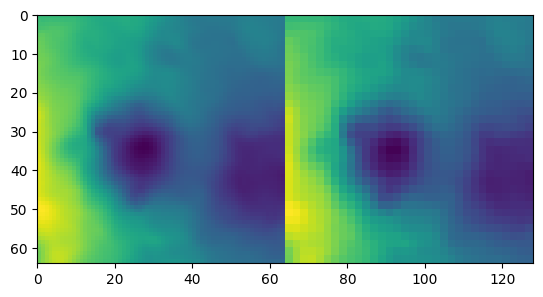

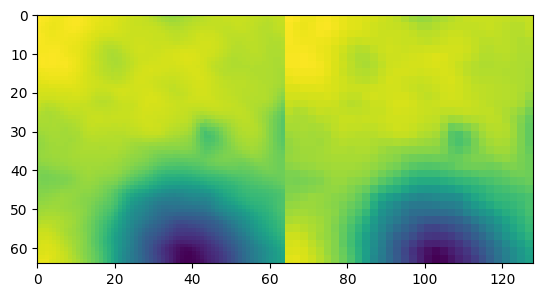

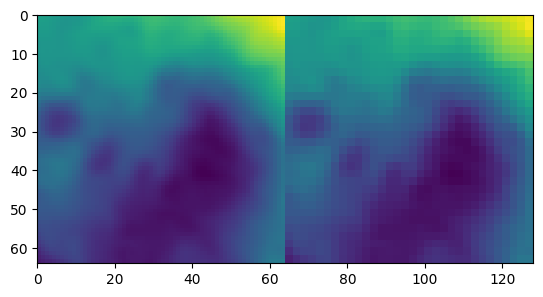

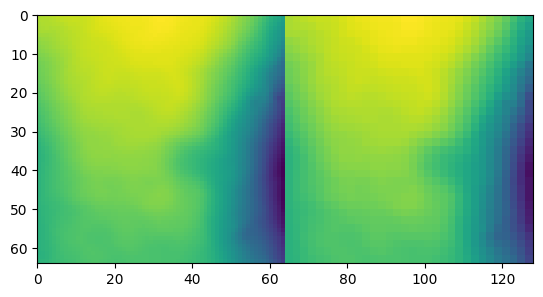

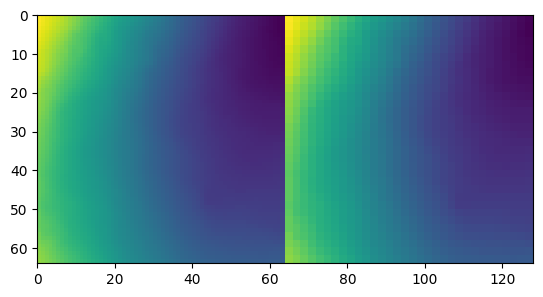

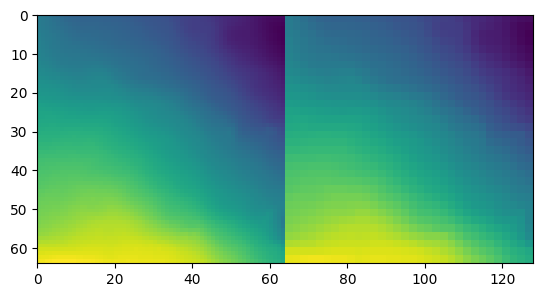

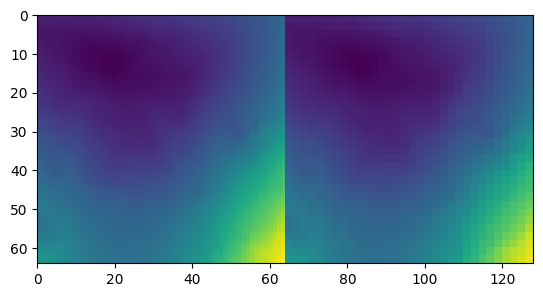

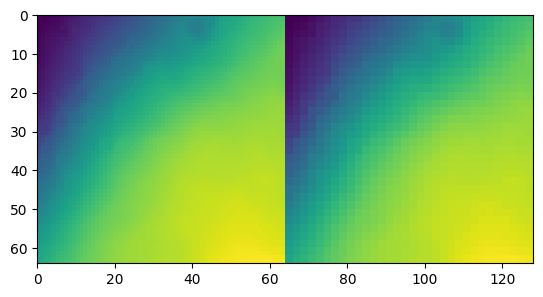

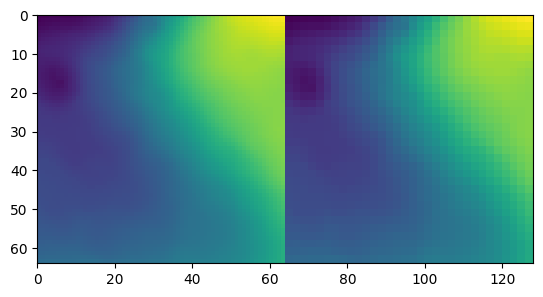

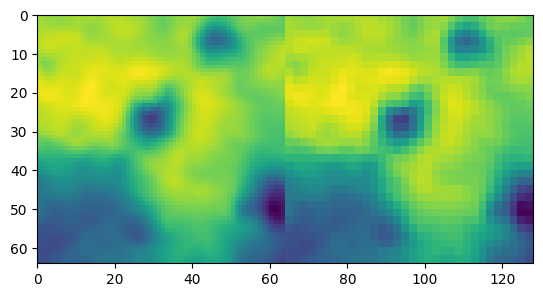

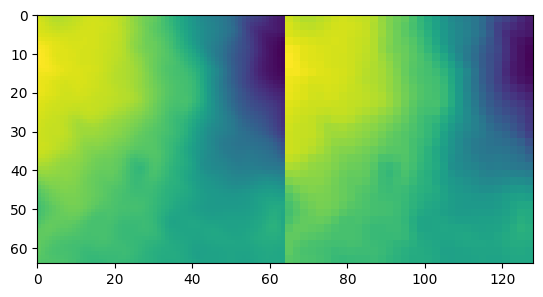

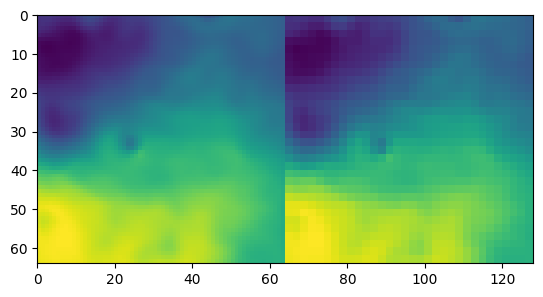

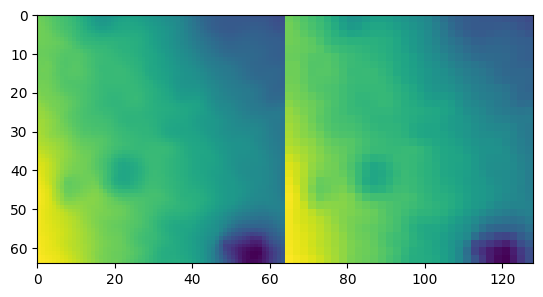

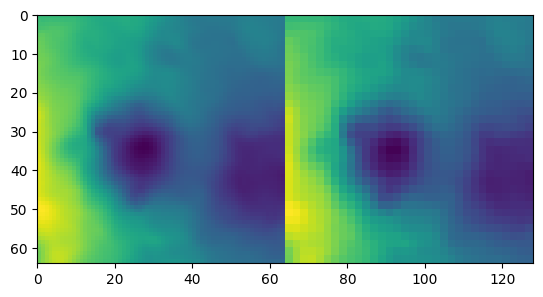

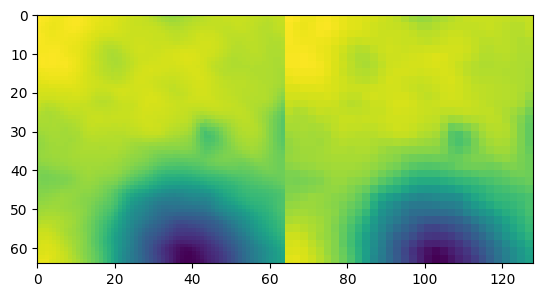

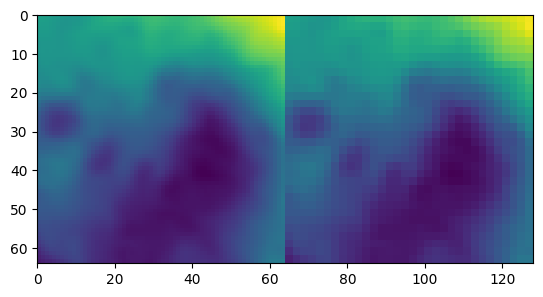

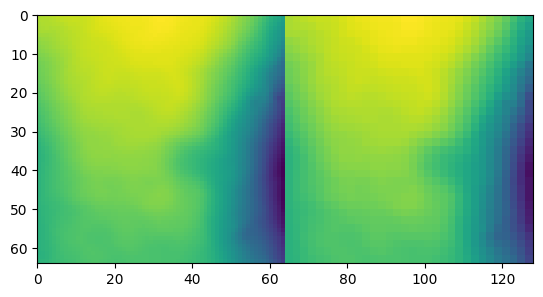

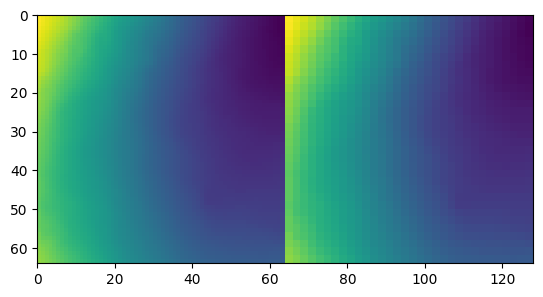

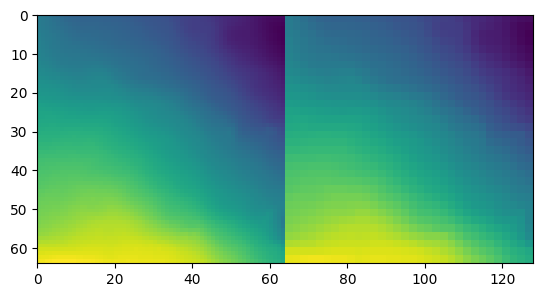

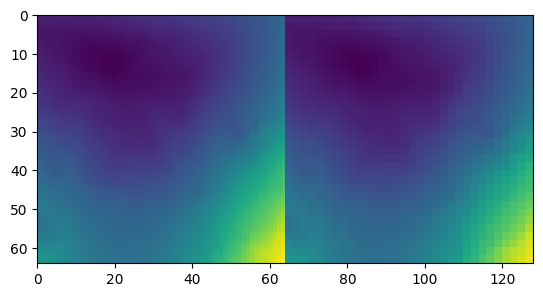

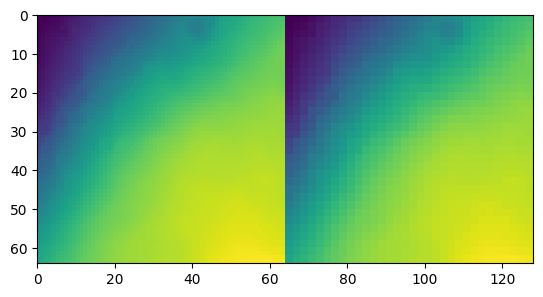

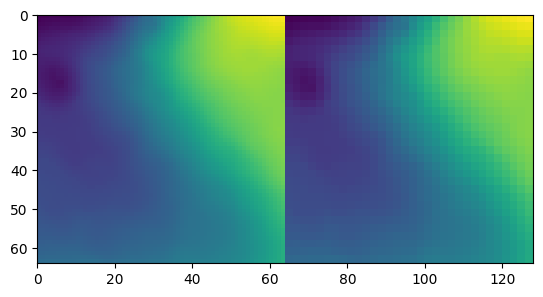

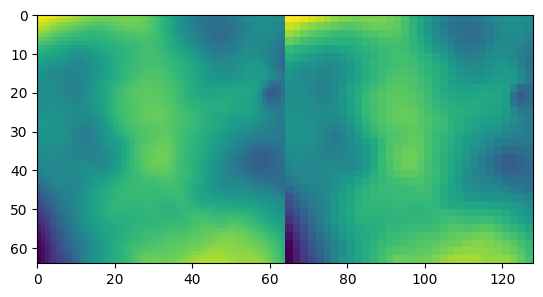

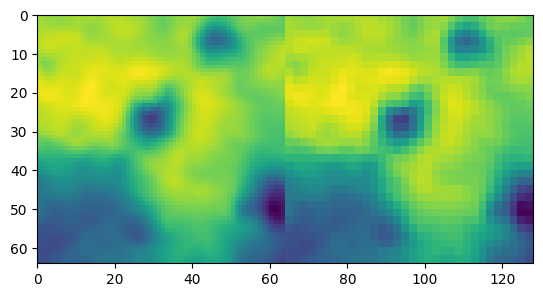

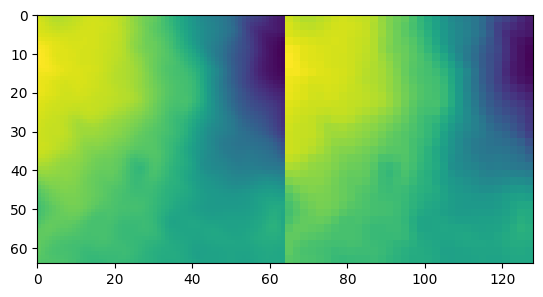

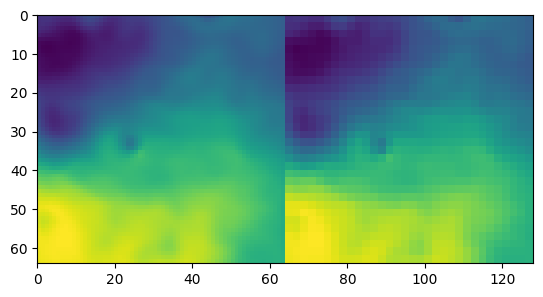

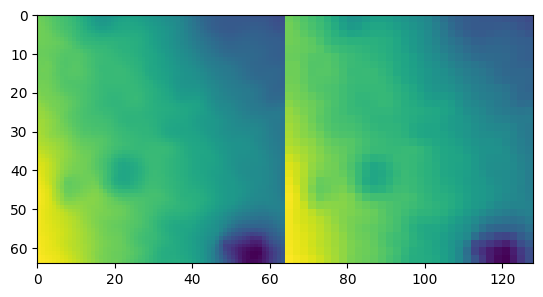

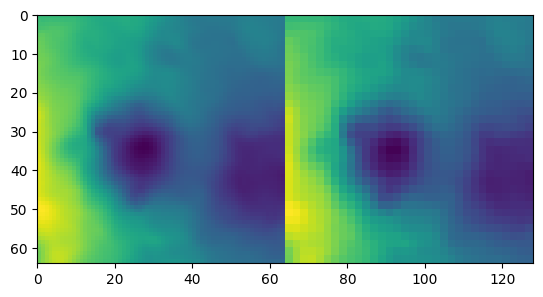

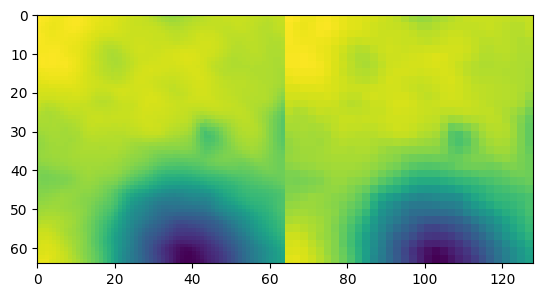

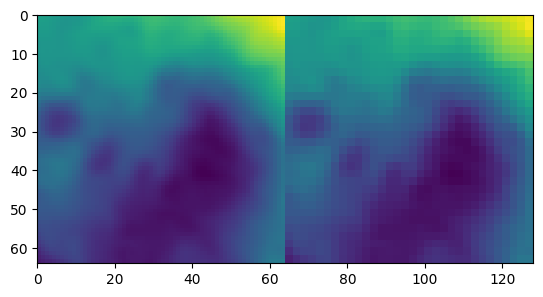

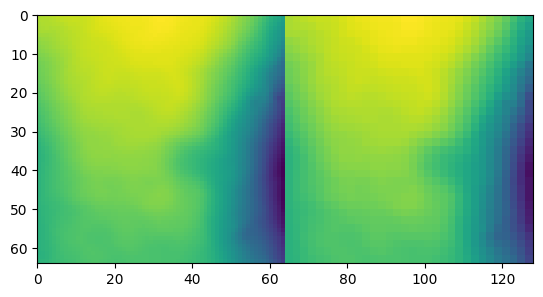

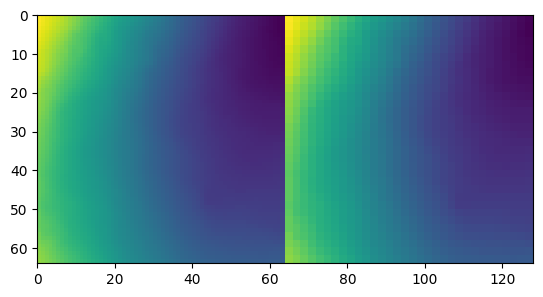

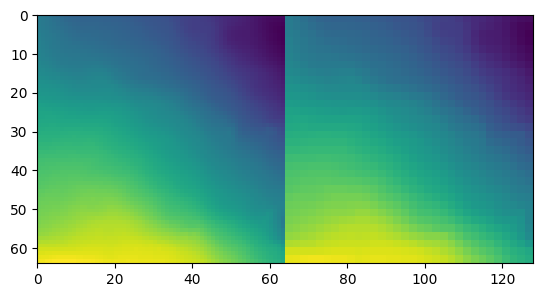

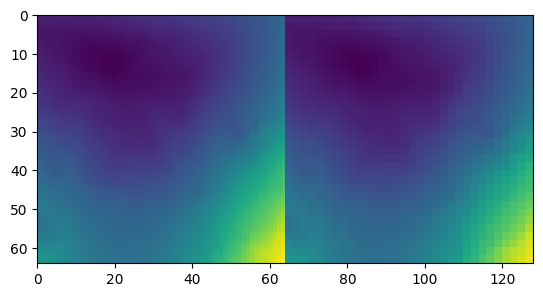

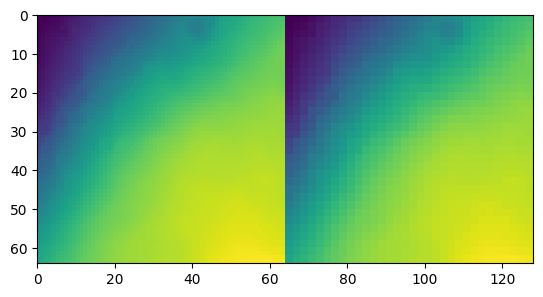

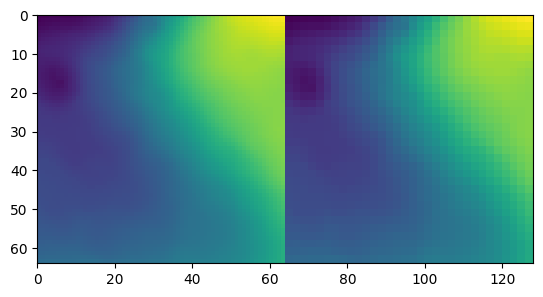

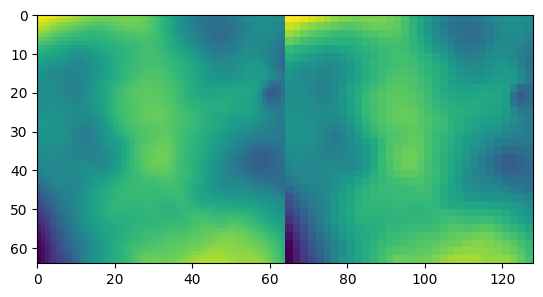

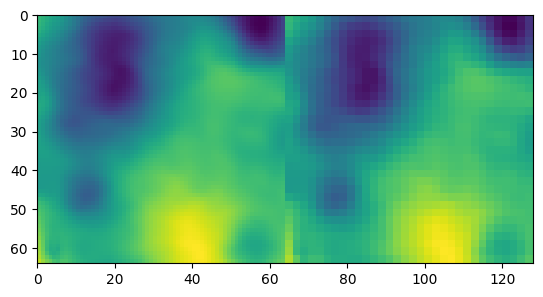

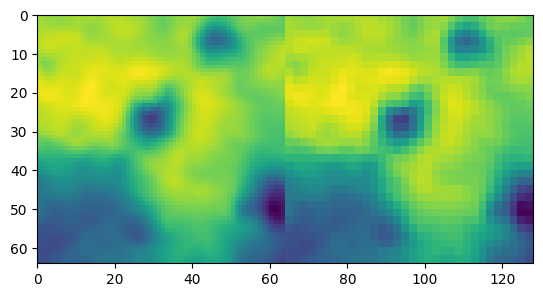

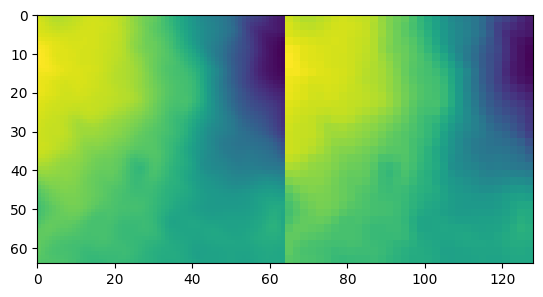

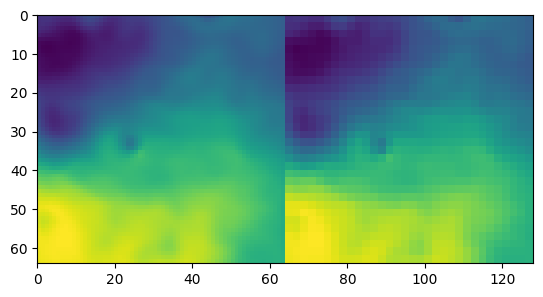

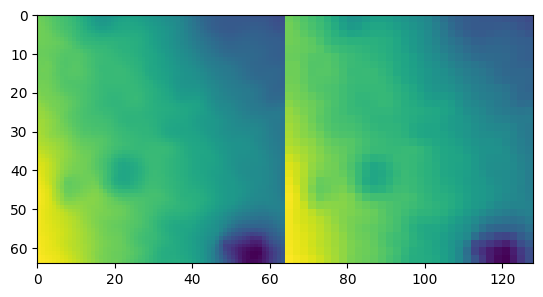

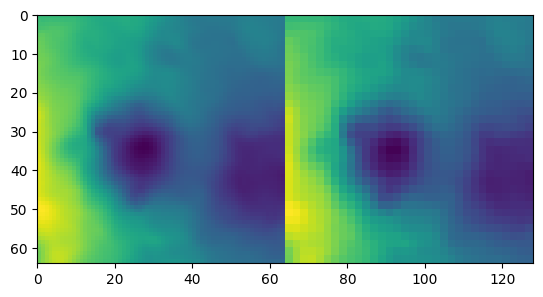

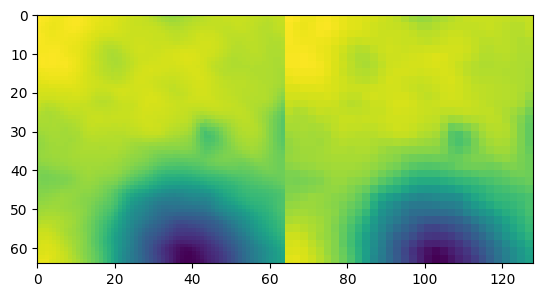

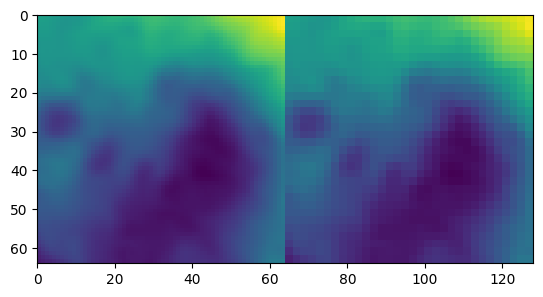

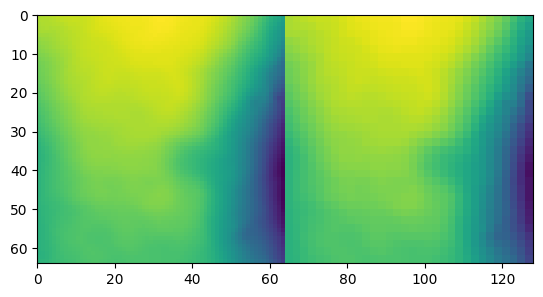

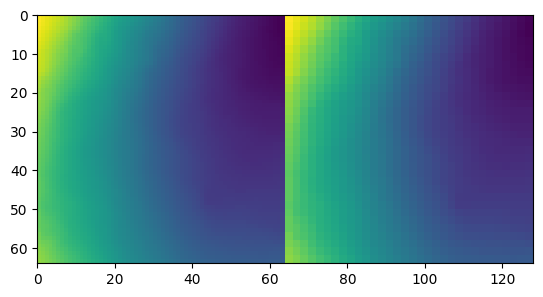

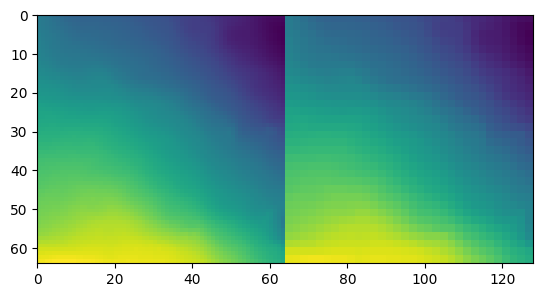

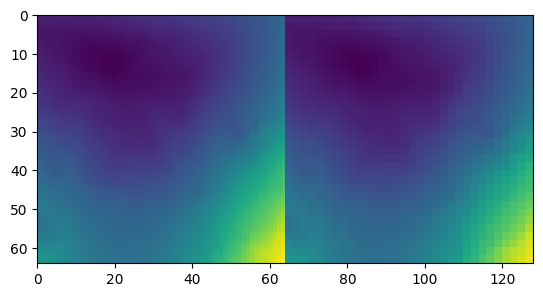

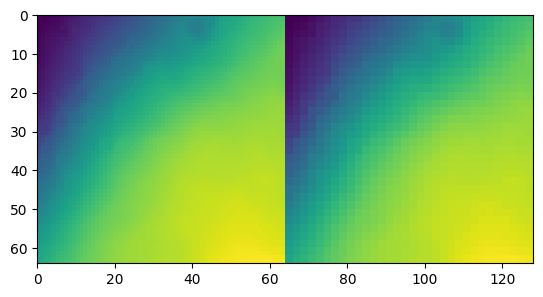

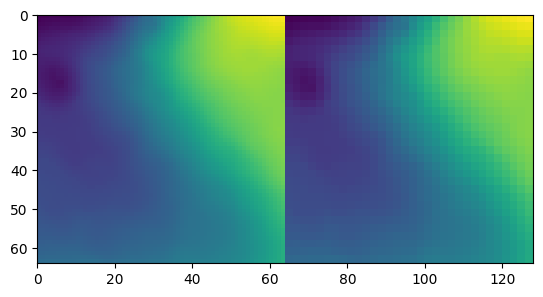

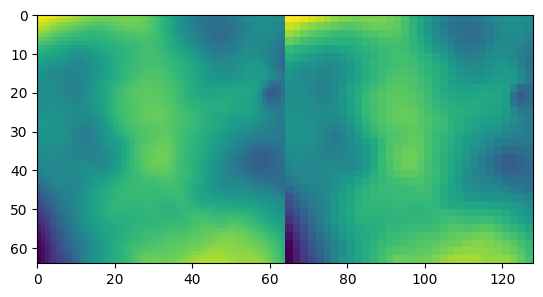

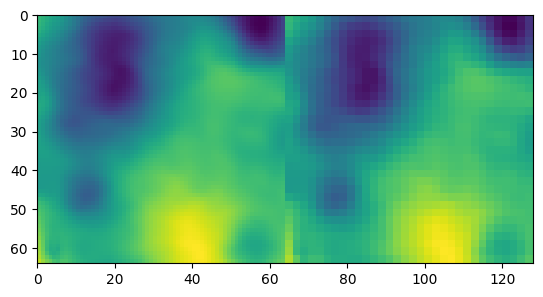

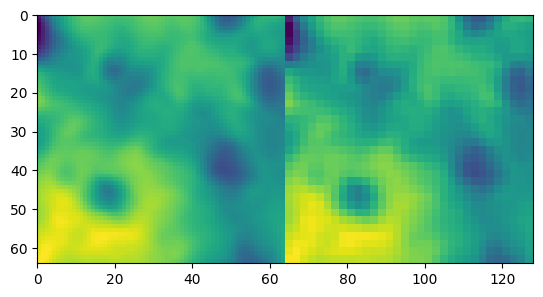

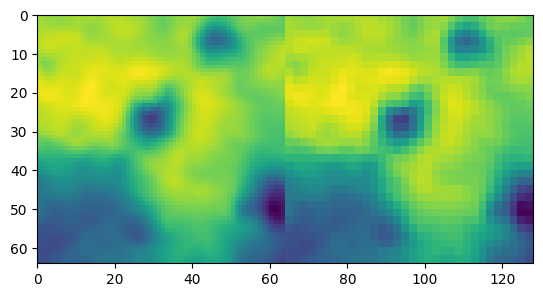

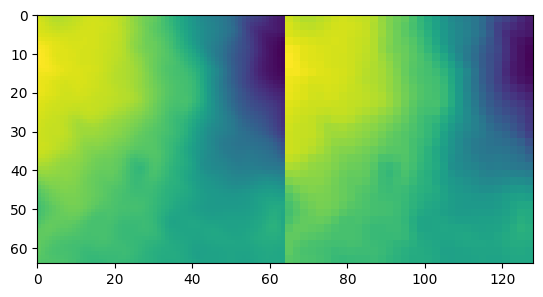

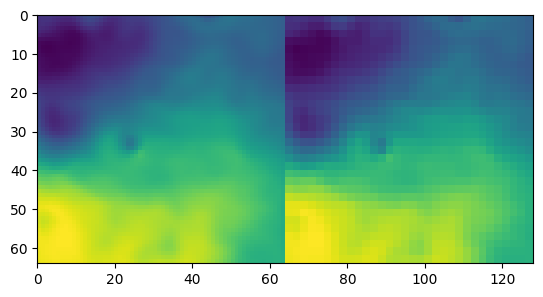

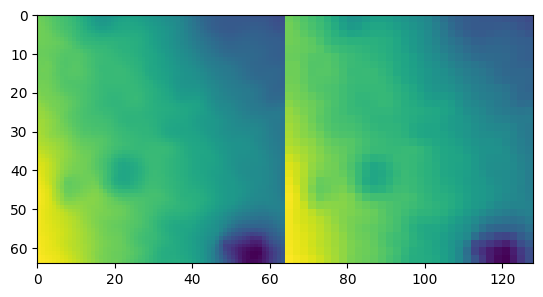

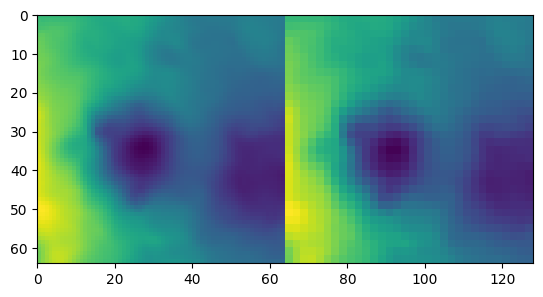

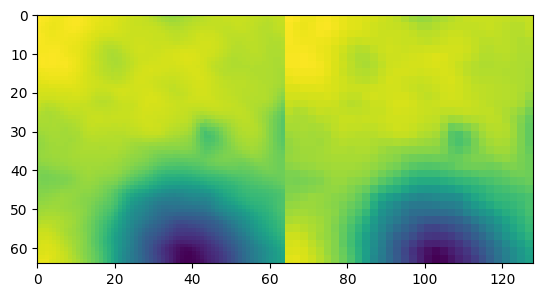

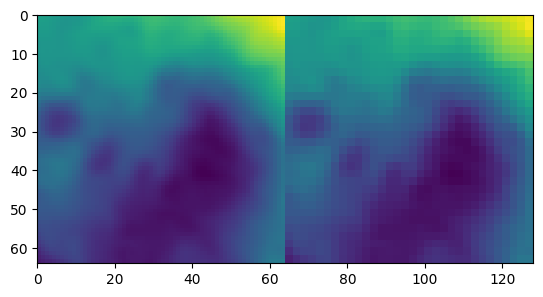

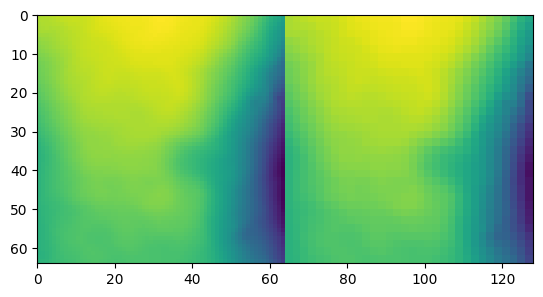

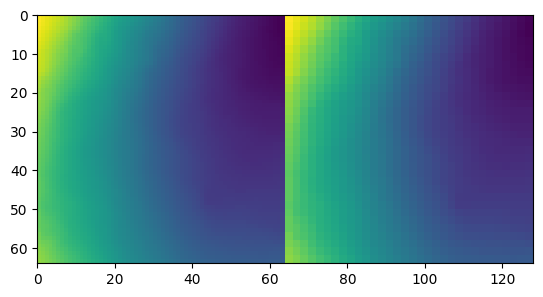

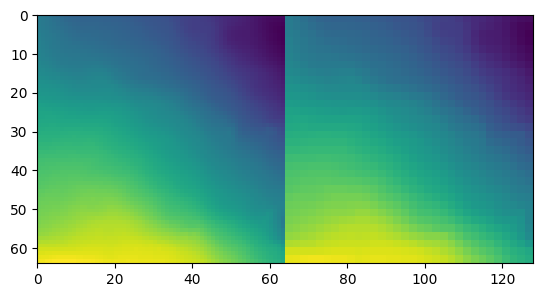

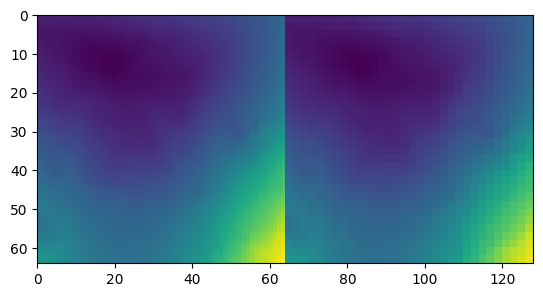

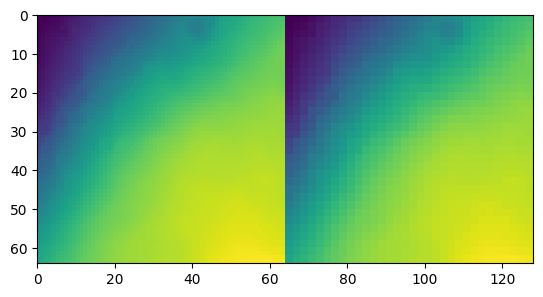

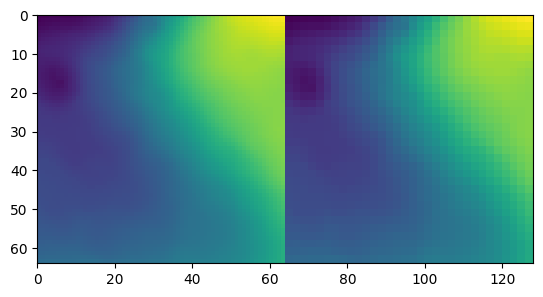

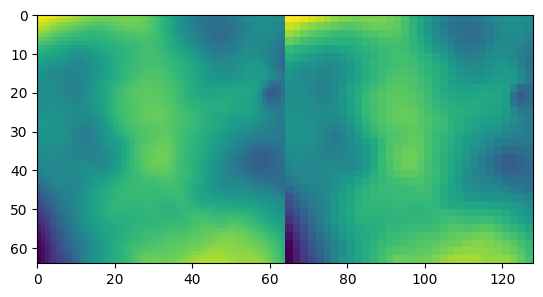

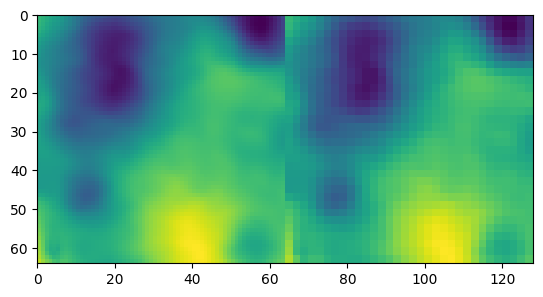

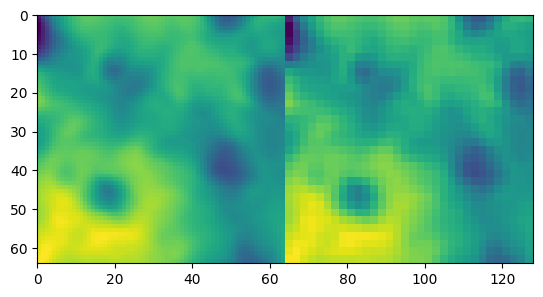

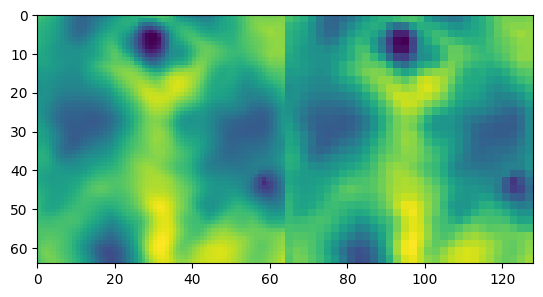

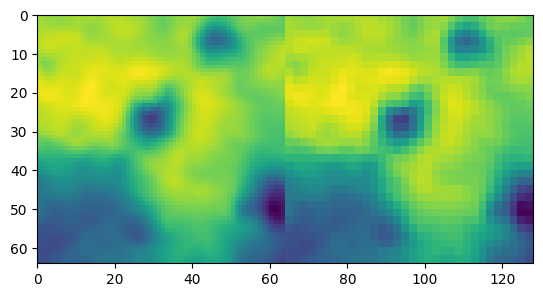

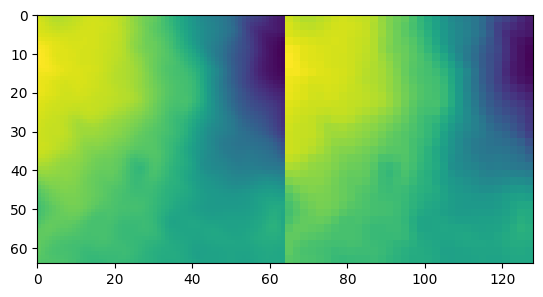

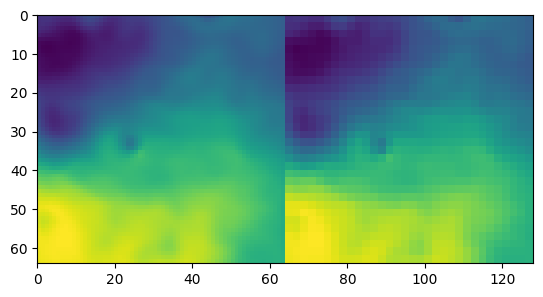

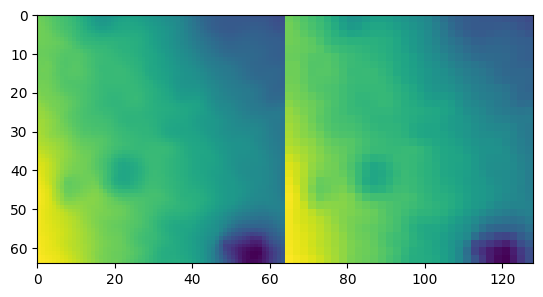

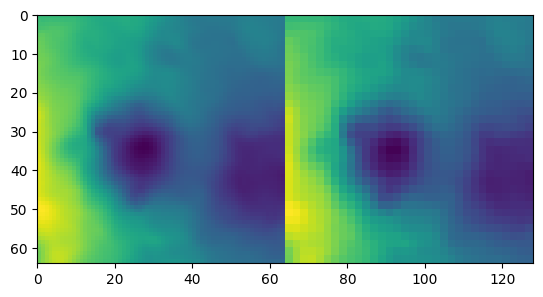

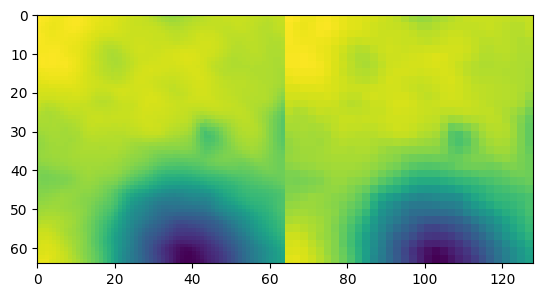

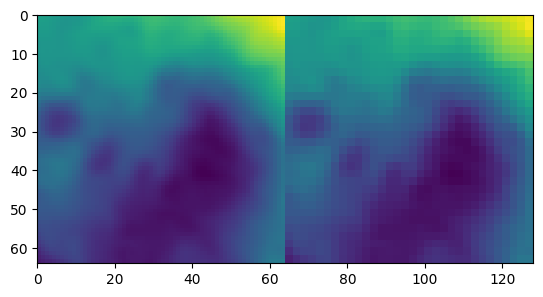

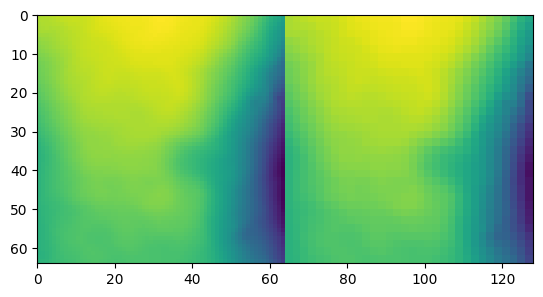

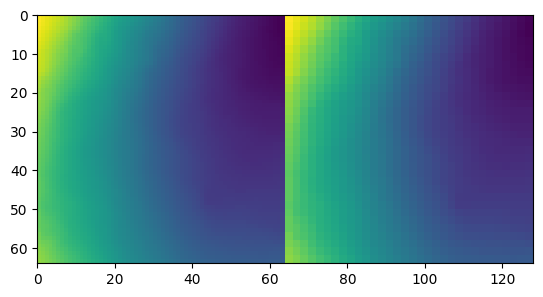

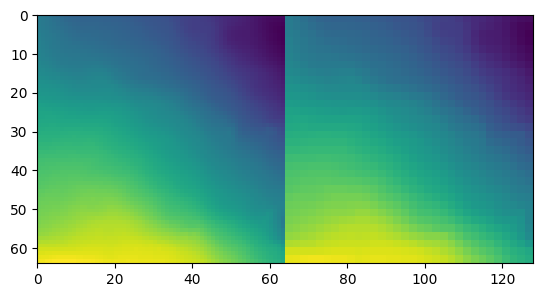

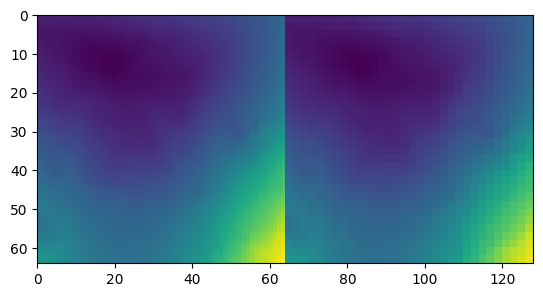

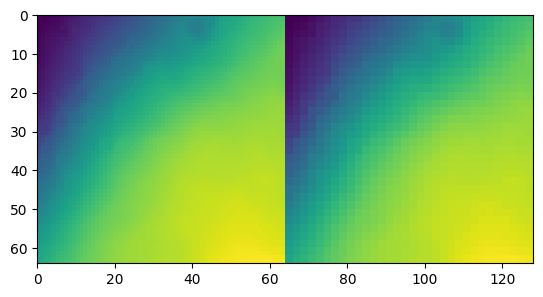

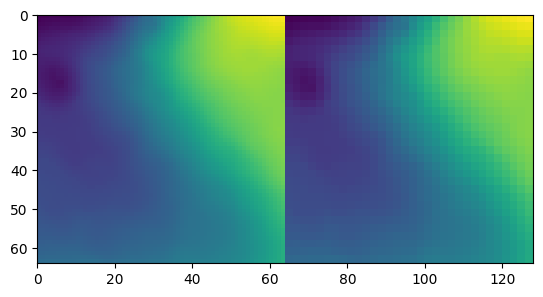

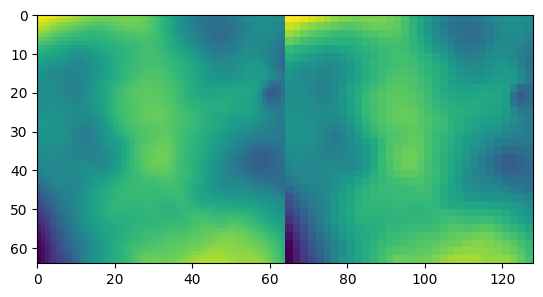

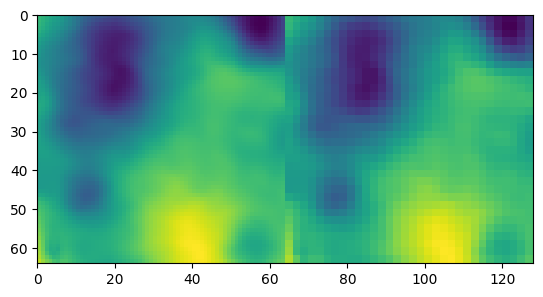

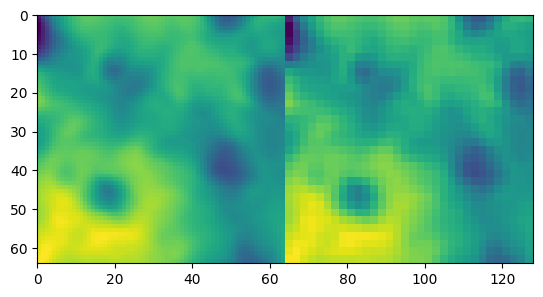

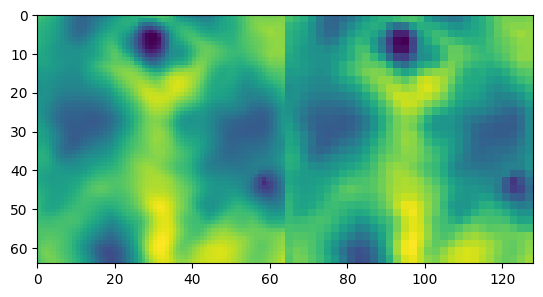

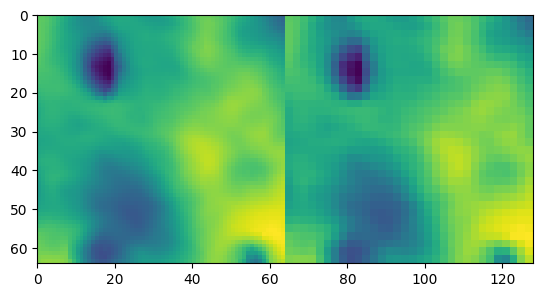

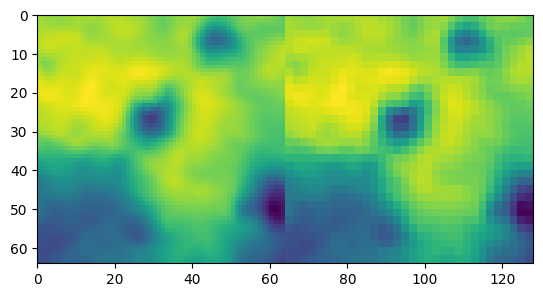

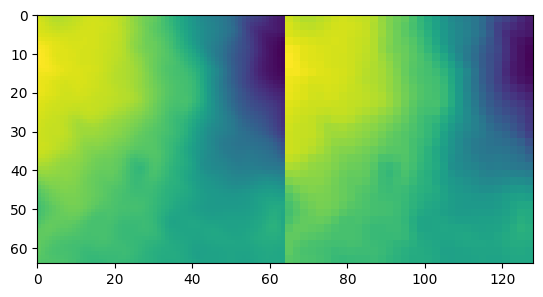

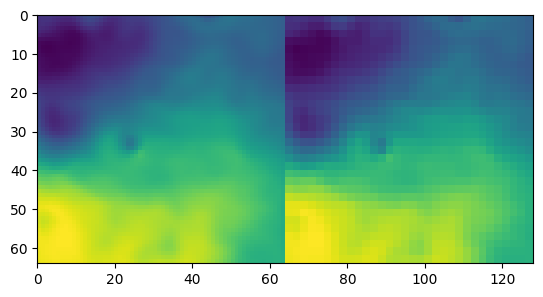

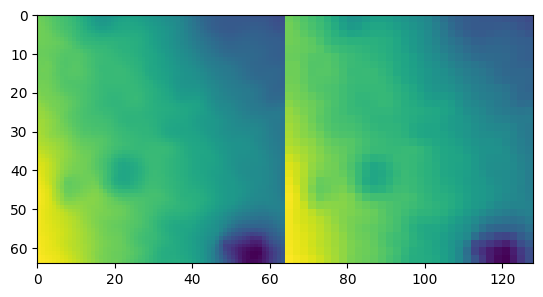

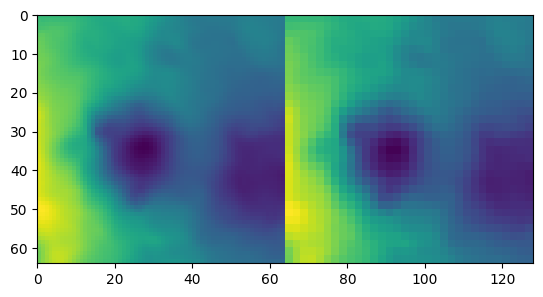

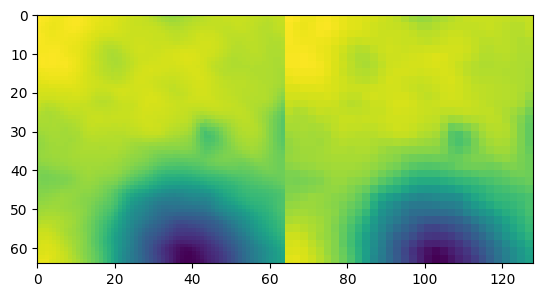

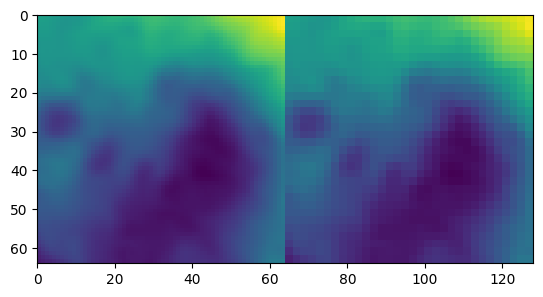

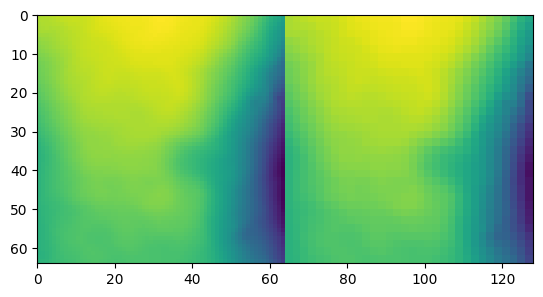

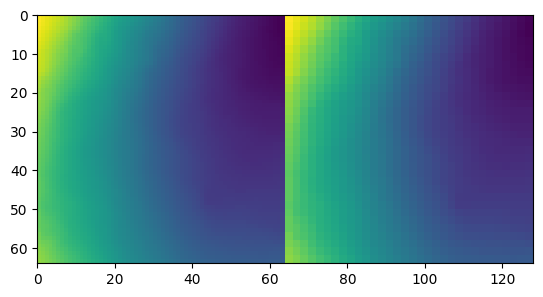

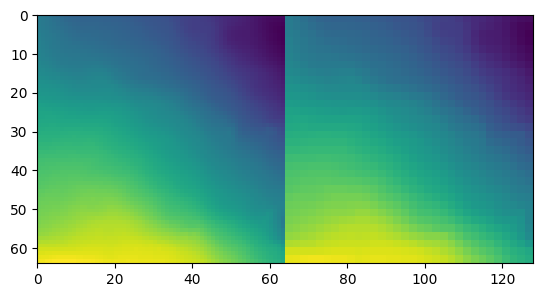

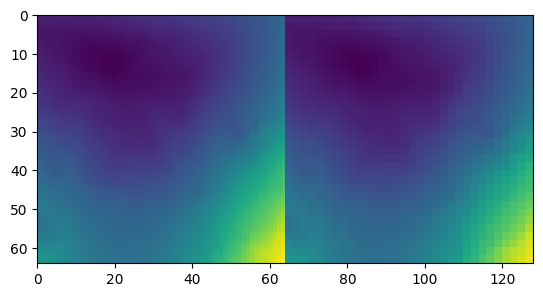

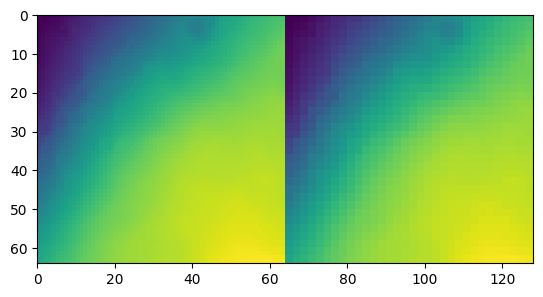

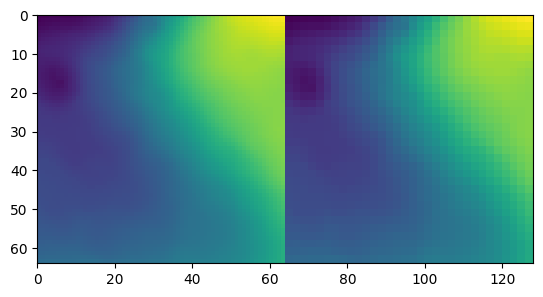

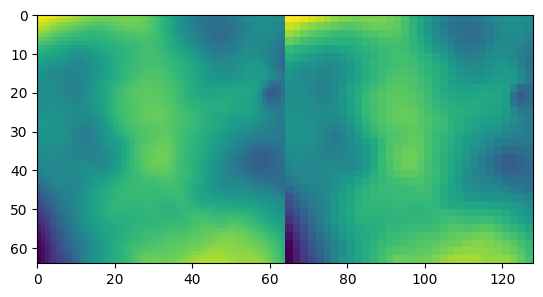

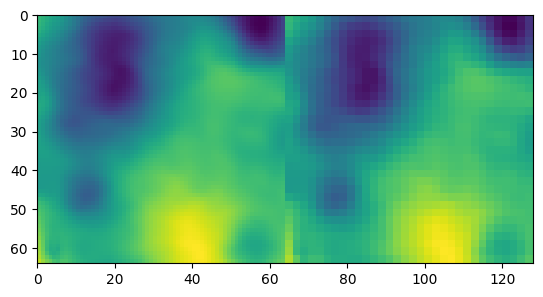

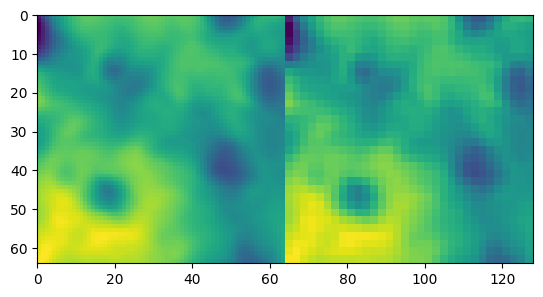

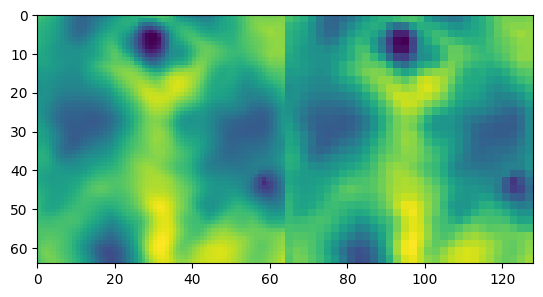

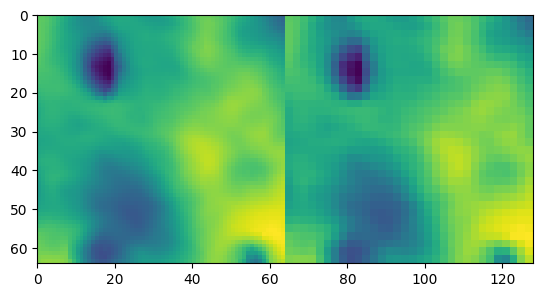

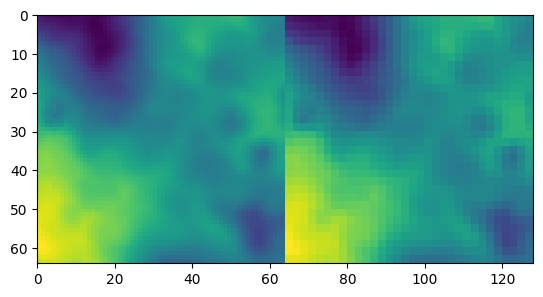

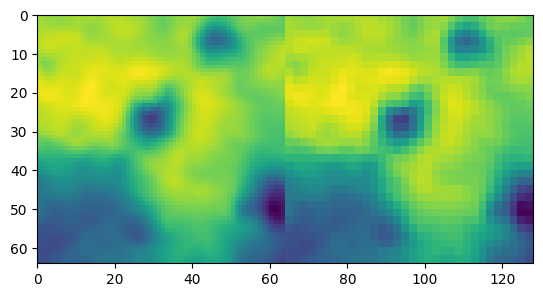

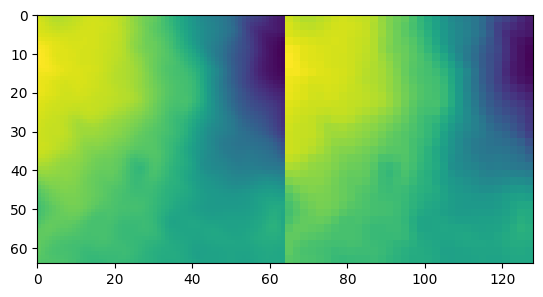

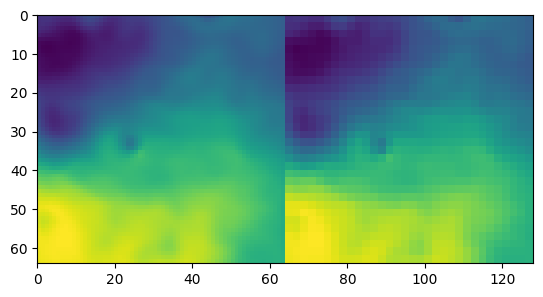

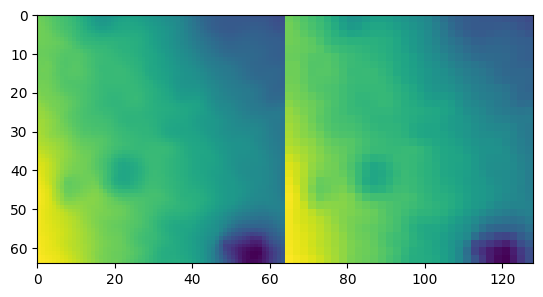

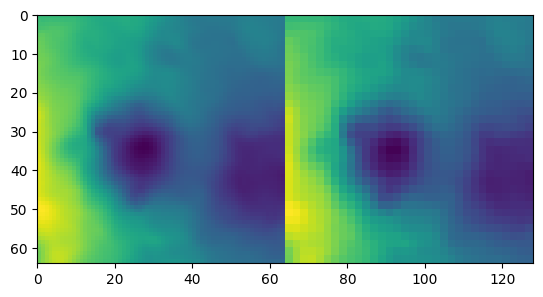

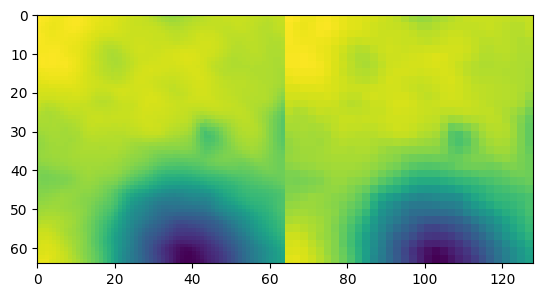

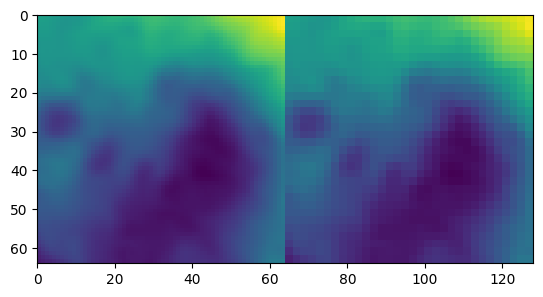

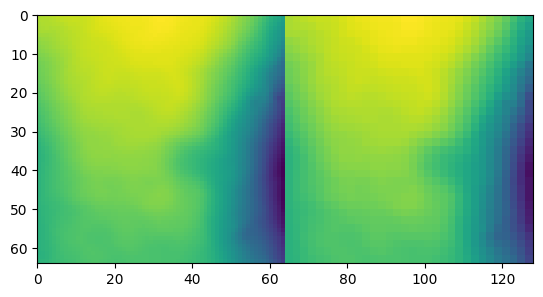

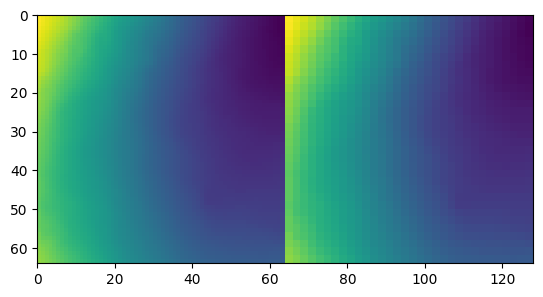

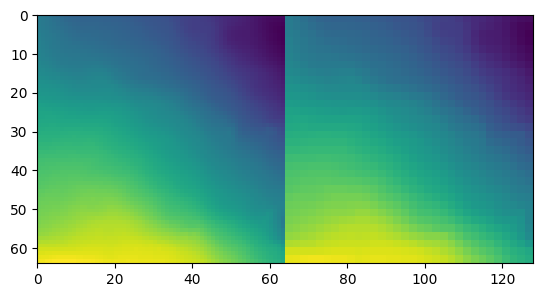

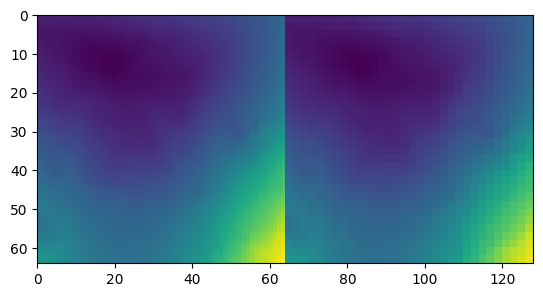

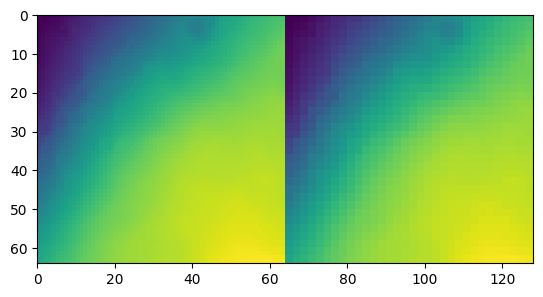

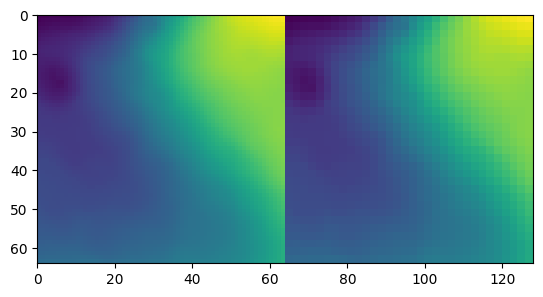

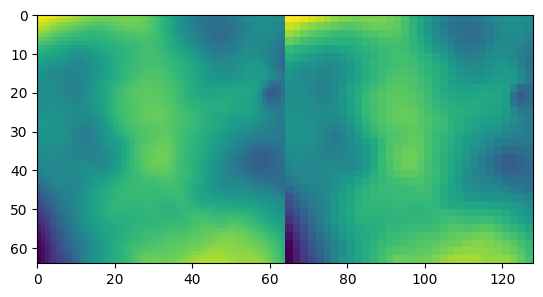

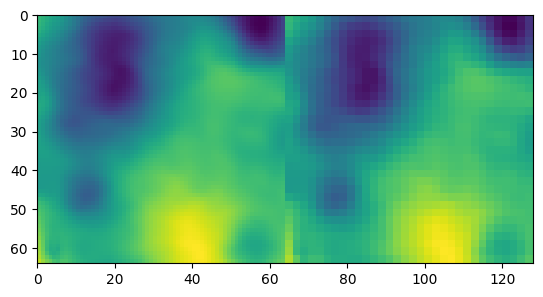

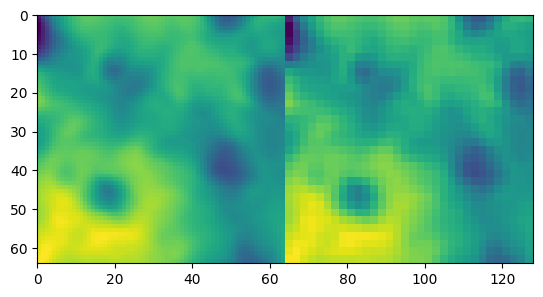

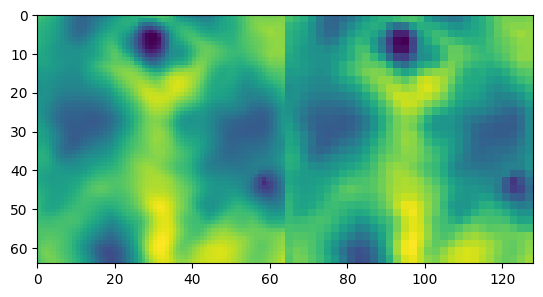

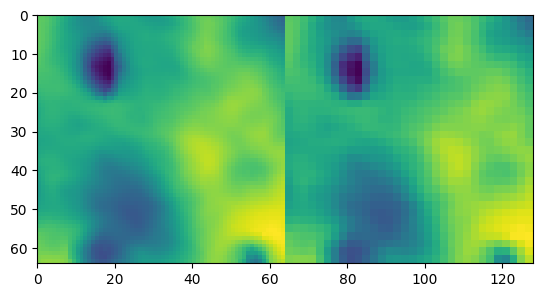

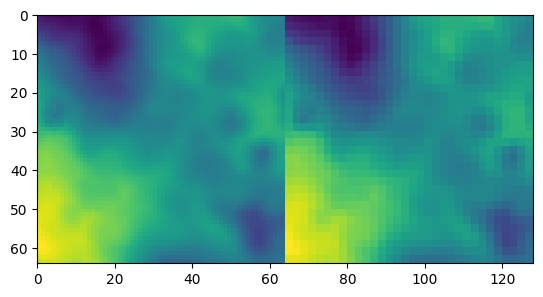

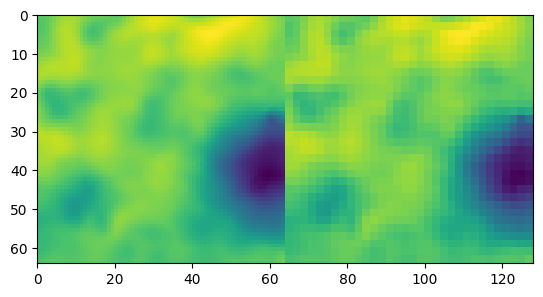

In [72]:
for index in range(20):
    fp = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/m" + str(index) + ".tif"
    img = rasterio.open(fp)
    show(img)

# Train the model


In [73]:
DATBASE_PATH = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/"
epoch = 0  # epoch to start training from 最初なので０にしました　もとは９９です
n_epochs = 250  # number of epochs of training
batch_size = 16  # size of the batches
lr = 0.0002  # adam: learning rate
b1 = 0.5  # decay of first order momentum of gradient
b2 = 0.999  # help="adam: decay of first order momentum of gradient
decay_epoch = 100  # help="epoch from which to start lr decay
n_cpu = 0  # help="number of cpu threads to use during batch generation
hr_height = 64  # high resolution image height
hr_width = 64  # high resolution image width
channels = 1  # number of image channels
sample_interval = 100  # interval between saving image samples")
checkpoint_interval = 10  # interval between model checkpoints

In [74]:
!nvidia-smi

1755.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


1755.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Mon Dec  8 12:21:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
|  0%   37C    P8             44W /  450W |    2609MiB /  24564MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [75]:
cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)
generator = GeneratorResNet()
c = C(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

feature_extractor.eval()

criterion_r = RMSELoss()

criterion_content = torch.nn.L1Loss()


if cuda:
    generator = generator.cuda()
    c = c.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_r = criterion_r.cuda()
    criterion_content = criterion_content.cuda()

if epoch != 0:
    generator.load_state_dict(
        torch.load(
            "/content/drive/MyDrive/GISR_code/GISR_checkpoint/generator_120.pth",
            map_location=torch.device('cpu') # GPUが利用できない場合にCPUにマップしてロード
        )
    )

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_C = torch.optim.Adam(c.parameters(), lr=lr * 0.1, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# min_valとmax_valが利用可能であることを確認し、ImageDatasetに渡してください
# 例: ImageDataset(DATBASE_PATH, hr_shape=hr_shape, global_min=min_val, global_max=max_val),
# 現在のコードではglobal_minとglobal_maxが渡されていないためエラーになる可能性があります。
# 以前の修正内容を反映することを推奨します。
# 例として、placeholderの値を入れておきますが、ご自身のDEMの正確なmin_valとmax_valに置き換えてください。
# （これらの値はコードセルの実行結果から取得できます。）

# --- Placeholder values for global_min and global_max ---
# 実際のmin_valとmax_valの値に置き換えてください
placeholder_min_val = -1289.3720703125 # fp_your_demで取得された実際の最小値
placeholder_max_val = -1185.1080322265625 # fp_your_demで取得された実際の最大値
# --------------------------------------------------------

dataloader = DataLoader(
    ImageDataset(DATBASE_PATH, hr_shape=hr_shape, global_min=placeholder_min_val, global_max=placeholder_max_val),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
writer = SummaryWriter(DATBASE_PATH + "/logs")


In [76]:
loss = []
for epoch in range(epoch, n_epochs):
    start = time.time()
    for i, imgs in enumerate(dataloader):

        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        valid = Variable(
            Tensor(np.ones((imgs_lr.size(0), *c.output_shape))), requires_grad=False
        )
        fake = Variable(
            Tensor(np.zeros((imgs_lr.size(0), *c.output_shape))), requires_grad=False
        )

        # -------------------
        #  Train Generator
        # -------------------

        optimizer_G.zero_grad()

        gen_hr = generator(imgs_lr)
        gen_hr = (gen_hr + imgs_lr) / 2

        # GANの要素を減らすために loss_r の重みを0にする (または非常に小さい値)
        # 知覚損失の要素を減らすために loss_content の重みも0にする (または非常に小さい値)
        loss_r = criterion_r(c(gen_hr), valid) * 0 # GAN要素を無効化

        real_dem_3c = torch.cat((imgs_hr, imgs_hr, imgs_hr), 1)
        gen_dem_3c = torch.cat((gen_hr, gen_hr, gen_hr), 1)
        gen_features = feature_extractor(gen_dem_3c)
        real_features = feature_extractor(real_dem_3c)
        loss_content = criterion_content(gen_features, real_features.detach()) * 0 # 知覚損失を無効化

        loss_RMSE = criterion_r(imgs_hr, gen_hr)

        # loss_G を再定義し、RMSE損失のみを強調する (または他の損失の重みを減らす)
        loss_G = loss_content + loss_r + 10 * loss_RMSE # loss_contentとloss_rは0になる

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # loss_r の重みが0の場合、Discriminatorの学習はGeneratorに影響しませんが、
        # コードの整合性を保つため、学習プロセスは残します。
        optimizer_C.zero_grad()

        # Real images
        loss_real = criterion_r(c(imgs_hr), valid)
        # Fake images
        loss_fake = criterion_r(c(gen_hr.detach()), fake)

        # Total Discriminator loss
        loss_C = (loss_real + loss_fake) / 2

        if i % 3 == 0:
            loss_C.backward()
            optimizer_C.step()

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d]  [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), loss_G.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            writer.add_scalar("loss_G", loss_G.item(), batches_done)
            writer.add_scalar("loss_RMSE", loss_RMSE.item(), batches_done)
            img_grid = torch.cat((imgs_lr, gen_hr, imgs_hr), -1)
            save_image(
                img_grid, DATBASE_PATH + "/%d.png" % batches_done, normalize=False
            )
    print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time() - start))
    loss.append(loss_G)
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(
            generator.state_dict(),
            "/home/s1300211/Documents/DEM-Super-Resolution/models/generator_%d.pth" % epoch,
        )


/tmp/ipykernel_1633529/124718370.py:10: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  Tensor(np.ones((imgs_lr.size(0), *c.output_shape))), requires_grad=False


/tmp/ipykernel_1633529/124718370.py:10: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  Tensor(np.ones((imgs_lr.size(0), *c.output_shape))), requires_grad=False


[Epoch 0/250] [Batch 0/34]  [G loss: 4.285287][Epoch 0/250] [Batch 1/34]  [G loss: 2.282520][Epoch 0/250] [Batch 2/34]  [G loss: 1.495767][Epoch 0/250] [Batch 3/34]  [G loss: 2.572753][Epoch 0/250] [Batch 4/34]  [G loss: 0.878022][Epoch 0/250] [Batch 5/34]  [G loss: 1.204256][Epoch 0/250] [Batch 6/34]  [G loss: 1.045110][Epoch 0/250] [Batch 7/34]  [G loss: 1.155527][Epoch 0/250] [Batch 8/34]  [G loss: 2.513584][Epoch 0/250] [Batch 9/34]  [G loss: 2.989427][Epoch 0/250] [Batch 5/34]  [G loss: 1.204256][Epoch 0/250] [Batch 6/34]  [G loss: 1.045110][Epoch 0/250] [Batch 7/34]  [G loss: 1.155527][Epoch 0/250] [Batch 8/34]  [G loss: 2.513584][Epoch 0/250] [Batch 9/34]  [G loss: 2.989427][Epoch 0/250] [Batch 10/34]  [G loss: 2.549744][Epoch 0/250] [Batch 11/34]  [G loss: 1.114976][Epoch 0/250] [Batch 12/34]  [G loss: 1.496085][Epoch 0/250] [Batch 13/34]  [G loss: 1.178412][Epoch 0/250] [Batch 14/34]  [G loss: 1.104014][Epoch 0/250] [Batch 10/34]  [G loss: 2.549744][Epoch 0/250] [Batch 11/34] 

/tmp/ipykernel_1633529/124718370.py:10: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  Tensor(np.ones((imgs_lr.size(0), *c.output_shape))), requires_grad=False


[Epoch 0/250] [Batch 0/34]  [G loss: 4.285287][Epoch 0/250] [Batch 1/34]  [G loss: 2.282520][Epoch 0/250] [Batch 2/34]  [G loss: 1.495767][Epoch 0/250] [Batch 3/34]  [G loss: 2.572753][Epoch 0/250] [Batch 4/34]  [G loss: 0.878022][Epoch 0/250] [Batch 5/34]  [G loss: 1.204256][Epoch 0/250] [Batch 6/34]  [G loss: 1.045110][Epoch 0/250] [Batch 7/34]  [G loss: 1.155527][Epoch 0/250] [Batch 8/34]  [G loss: 2.513584][Epoch 0/250] [Batch 9/34]  [G loss: 2.989427][Epoch 0/250] [Batch 5/34]  [G loss: 1.204256][Epoch 0/250] [Batch 6/34]  [G loss: 1.045110][Epoch 0/250] [Batch 7/34]  [G loss: 1.155527][Epoch 0/250] [Batch 8/34]  [G loss: 2.513584][Epoch 0/250] [Batch 9/34]  [G loss: 2.989427][Epoch 0/250] [Batch 10/34]  [G loss: 2.549744][Epoch 0/250] [Batch 11/34]  [G loss: 1.114976][Epoch 0/250] [Batch 12/34]  [G loss: 1.496085][Epoch 0/250] [Batch 13/34]  [G loss: 1.178412][Epoch 0/250] [Batch 14/34]  [G loss: 1.104014][Epoch 0/250] [Batch 10/34]  [G loss: 2.549744][Epoch 0/250] [Batch 11/34] 

RuntimeError: Parent directory /content/drive/MyDrive/GISR_code/models does not exist.

In [ ]:
loss_list = [tensor.item() for tensor in loss]

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss curve

x = range(0, 250)  #epochを９９から０にしたのでこちらも９９から０にしました

plt.plot(x, loss_list, label="Training Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")

plt.title("Training Loss Curve")

plt.legend()

plt.show()

In [ ]:
!ls /content/drive/MyDrive/GISR_code/models/generator_*

# Model testing


In [ ]:
import argparse
from skimage import io
import os
import numpy as np
import math
import itertools
import tifffile as tiff
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import glob
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import time
import datetime
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(
            *list(vgg19_model.features.children())[:18]
        )

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU()
        )

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
        )

        # Upsampling layers
        upsampling = []
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                # nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=9, stride=2, padding=4), nn.Tanh()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class D(nn.Module):
    def __init__(self, input_shape):
        super(D, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2**4), int(in_width / 2**4)
        self.output_shape = (1, patch_h, patch_w)

        def d_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(
                nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1)
            )
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(
                nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1)
            )
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(d_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, truth):
        return torch.sqrt(torch.mean((pred - truth) ** 2))
        torch.square((pred - truth) ** 2)

## Load the model


In [91]:
path = "/home/s1300211/Documents/datasets/test"  # Your folder path
sample = "center_tile"  # Your file name of tiff
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
lr = 0.0002
b1 = 0.5
b2 = 0.999
hr_height = 64
hr_width = 64
h = 1414.8213    # もとは2335
l = 482.3734     # もとは304
cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)
generator = GeneratorResNet()
feature_extractor = FeatureExtractor()
feature_extractor.eval()
criterion_GAN = RMSELoss()
criterion_content = torch.nn.L1Loss()
if cuda:
    generator = generator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()
generator.load_state_dict(
    torch.load("/home/s1300211/Documents/DEM-Super-Resolution/models/generator_240.pth")
)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## Generate test data


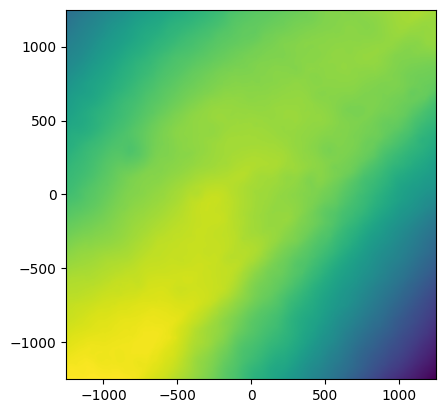

<Axes: >

In [92]:
import rasterio
from rasterio.plot import show

fp = r"/home/s1300211/Documents/datasets/test/center_tile.tif"
img = rasterio.open(fp)
show(img)

In [93]:
img.width

500

In [94]:
img.height

500

In [95]:
img_lr = img.read()[0]

In [96]:
img_lr.shape

(500, 500)

## Split image into 64\*64 images


In [97]:
M, N = 64, 64
images_tiles = [
    img_lr[x : x + M, y : y + N]
    for x in range(0, img_lr.shape[0], M)
    for y in range(0, img_lr.shape[1], N)
]

In [98]:
# we get 169 images
len(images_tiles)

64

In [99]:
H, W = img_lr.shape
if W % M == 0:
    n_w = int(W / M)
else:
    n_w = int(W / M) + 1
if H % N == 0:
    n_h = int(H / N)
else:
    n_h = int(H / N) + 1

In [100]:
# for i in images_tiles:
#   print(i.shape)

# All tiles to 64x64


In [101]:
# There are some images that are not 64x64. The goal of this code is to transform all images to 64x64 without changing the information in the images.
new_tiles = []
N_w = n_w
new_tiles = []
tiles_index = []
operation_type = []
added_col_or_arr_number = []
added_col_or_arr_number_last_tile = []
images_tiles = [
    img_lr[x : x + M, y : y + N]
    for x in range(0, img_lr.shape[0], M)
    for y in range(0, img_lr.shape[1], N)
]
for img_index in range(len(images_tiles)):
    if images_tiles[img_index].shape != (64, 64):
        if images_tiles[img_index].shape[0] == 64:
            # Add pixels (column) from previous tile
            n = 64 - images_tiles[img_index].shape[1]
            # Select the last n columns using negative indexing
            last_n_columns = images_tiles[img_index - 1][:, -n:]
            # Create a new tile by horizontally stacking last_n_columns and images_tiles[img_index]
            new_tile = np.hstack((last_n_columns, images_tiles[img_index]))
            new_tiles.append(new_tile)
            tiles_index.append(img_index)
            operation_type.append("columns added")
            added_col_or_arr_number.append(n)
        if images_tiles[img_index].shape[1] == 64:
            # Add pixels (rows) from previous tile
            n = 64 - images_tiles[img_index].shape[0]
            # Select the last n rows using negative indexing
            last_n_rows = images_tiles[img_index - N_w][-n:, :]
            # Create a new tile by vertically stacking last_n_rows and images_tiles[img_index]
            new_tile = np.vstack((last_n_rows, images_tiles[img_index]))
            # images_tiles[img_index] = new_tile
            new_tiles.append(new_tile)
            tiles_index.append(img_index)
            operation_type.append("rows added")
            added_col_or_arr_number.append(n)
        if (
            images_tiles[img_index].shape[1] != 64
            and images_tiles[img_index].shape[0] != 64
        ):
            index_ = 0
            for index in tiles_index:
                images_tiles[index] = new_tiles[index_]
                index_ += 1
            n_w_ = 64 - images_tiles[img_index].shape[1]
            # Select the last n columns using negative indexing
            last_n_columns = images_tiles[img_index - 1][:, -n_w_:]
            # Create a new tile by horizontally stacking last_n_columns and images_tiles[img_index]
            new_tile_w = np.hstack(
                (
                    last_n_columns[-images_tiles[img_index].shape[0] :, :],
                    images_tiles[img_index],
                )
            )
            n_h_ = 64 - images_tiles[img_index].shape[0]
            # Select the last n rows using negative indexing
            last_n_rows = images_tiles[img_index - N_w][-n_h_:, :]
            # Create a new tile by vertically stacking last_n_rows and images_tiles[img_index]
            new_tile = np.vstack((last_n_rows, new_tile_w))
            # Replace the current tile with the new tile
            images_tiles[img_index] = new_tile
            tiles_index.append(img_index)
            operation_type.append("rows and columns added")
            added_col_or_arr_number_last_tile.append(n_w_)
            added_col_or_arr_number_last_tile.append(n_h_)

In [103]:
# save images
index = 0
path = "/home/s1300211/Documents/DEM-Super-Resolution/dataset/"
for img in images_tiles:
    tiff.imwrite(path + "/" + "lr_test_" + str(index) + ".tif", img)
    index += 1

/home/s1300211/Documents/venv_2/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


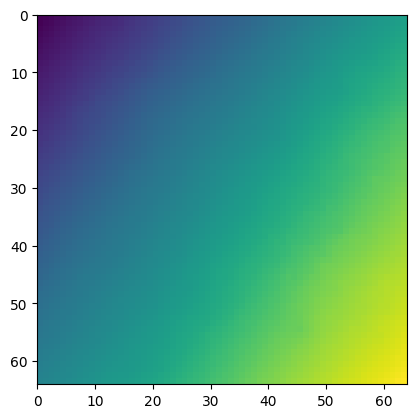

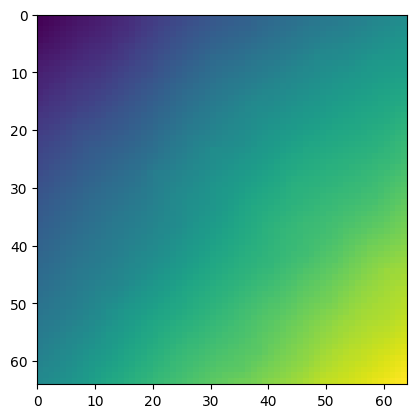

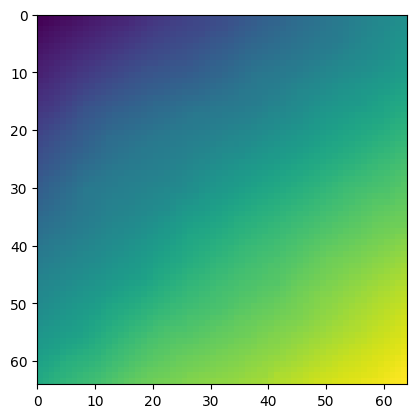

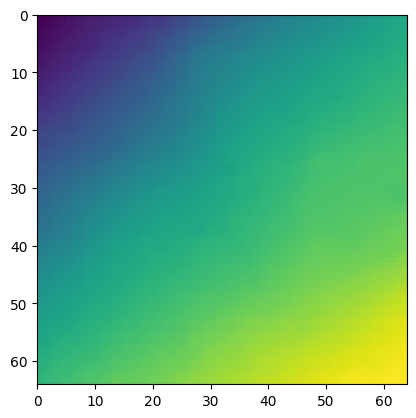

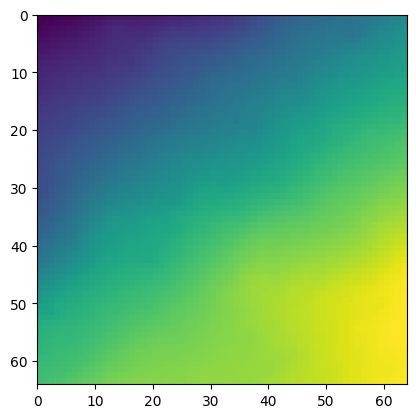

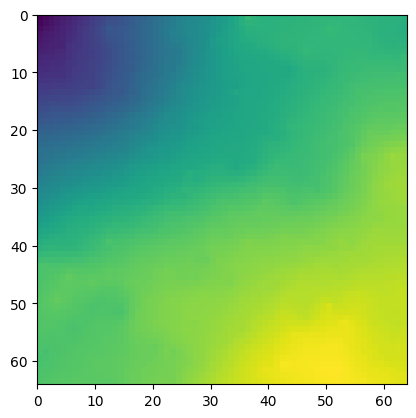

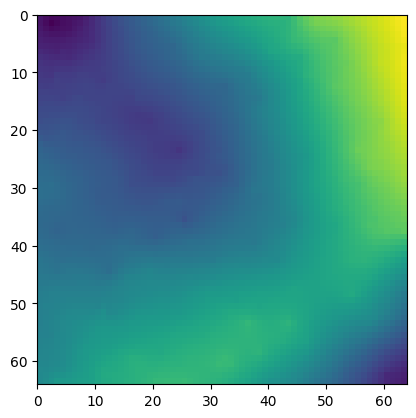

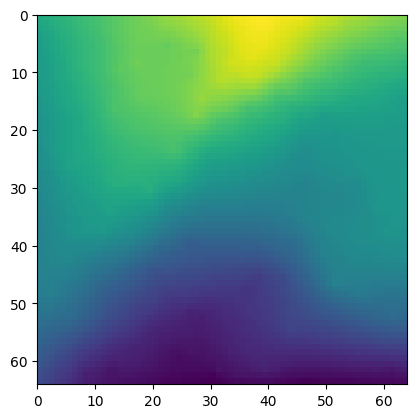

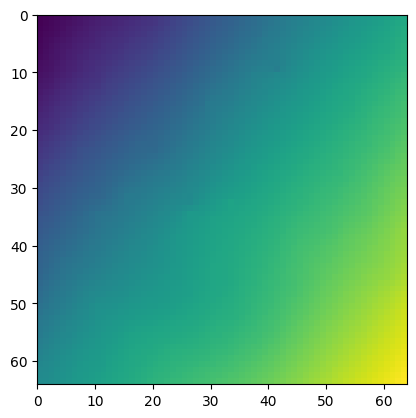

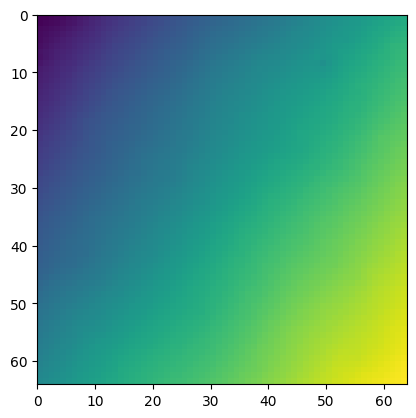

In [104]:
for index in range(10):
    fp = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/lr_test_" + str(index) + ".tif"
    img = rasterio.open(fp)
    show(img)

In [105]:
# for i in images_tiles:
#   print(i.shape)

## Use the model to get HR


In [106]:
for i in range(len(images_tiles)):
    filename = DATBASE_PATH + "/lr_test_"
    img_hr = io.imread(filename + str(i) + ".tif")
    a = img_hr
    a1 = a
    a111 = a[:, :64]
    a2 = (a1 - -1185.108) / ((-1289.3721 - -1185.108) / 2) - 1   # a2 = (a1) / ((932.4479 - 0) / 2) - 1 がもとです。
    a3 = np.expand_dims(a2, 0)
    a4 = np.expand_dims(a3, 0)
    a5 = a4.astype(np.float32)
    a6 = torch.tensor(a5)
    Tensor = torch.cuda.FloatTensor
    a7 = Variable(a6.type(Tensor))
    a8 = generator(a7)
    a9 = (a8 + a7) / 2
    a10 = (a9 + 1) * ((h - l) / 2) + l      # 最後に +ｌを追加
    a11 = a10.cpu().detach().numpy()
    tiff.imwrite(DATBASE_PATH + "gene_hr" + str(i) + ".tif", a11[0, 0, :, :])

# Visualize HR results


/home/s1300211/Documents/venv_2/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


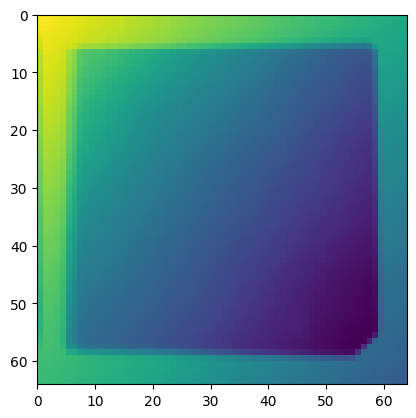

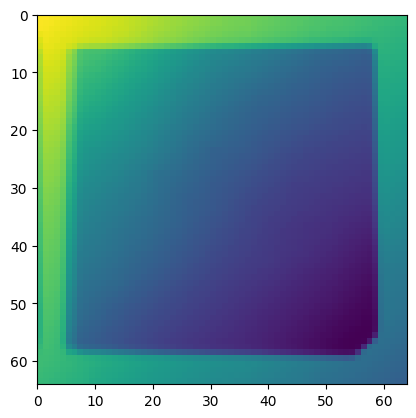

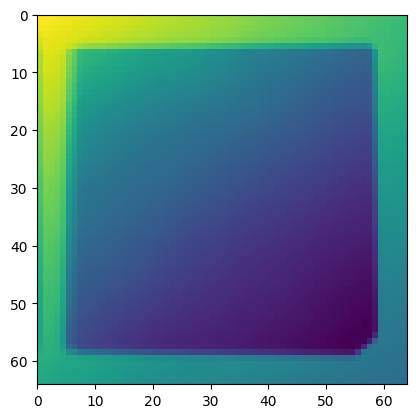

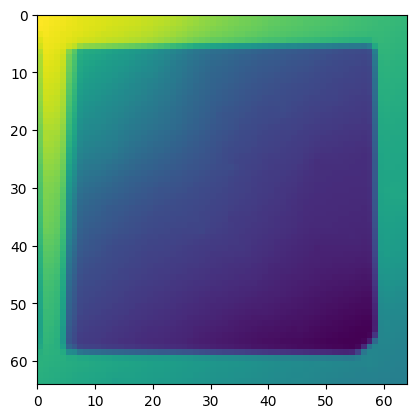

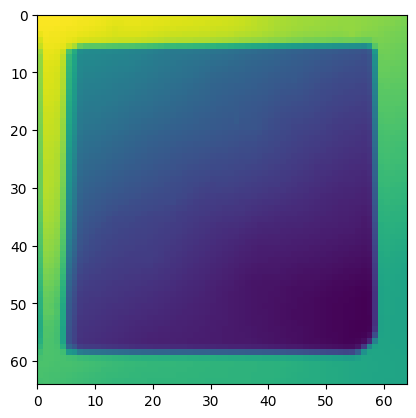

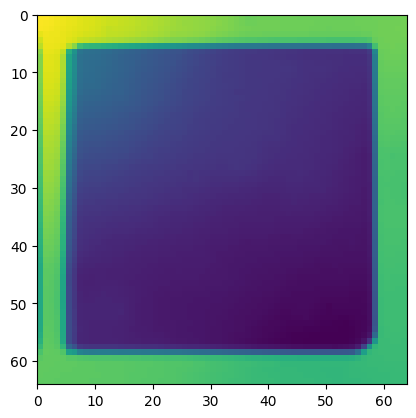

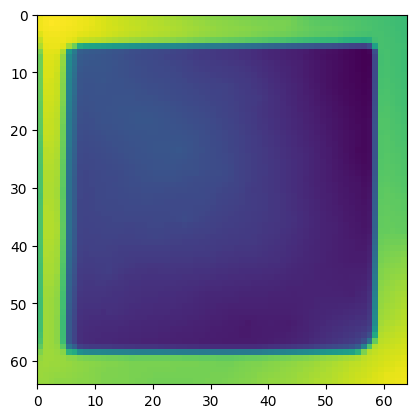

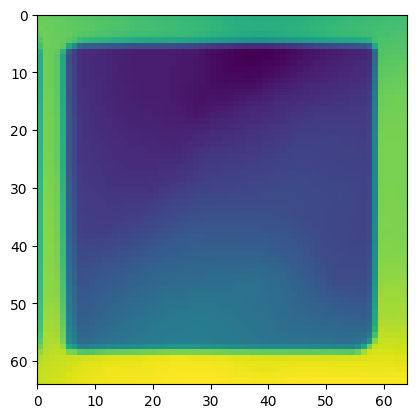

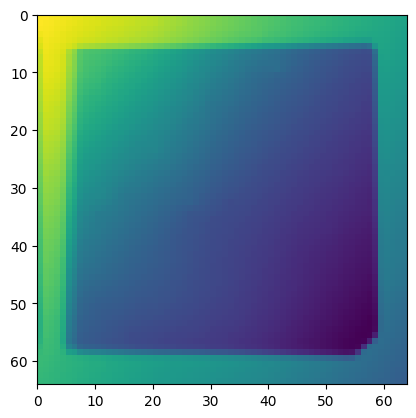

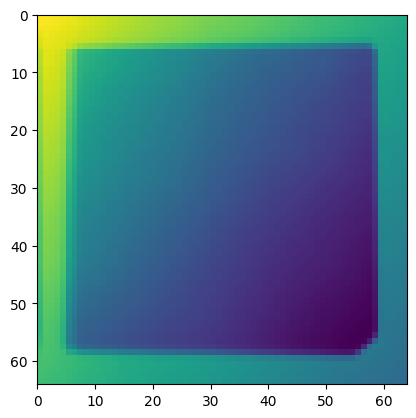

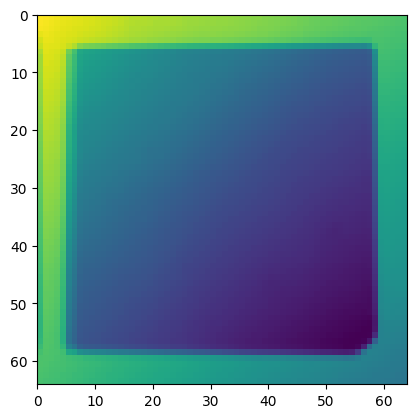

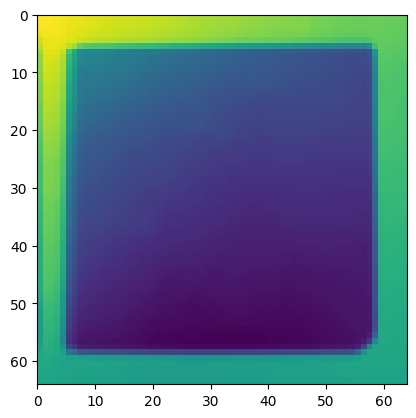

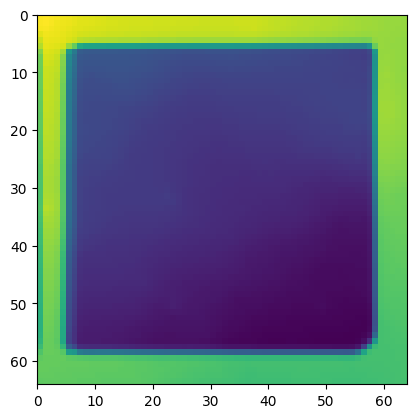

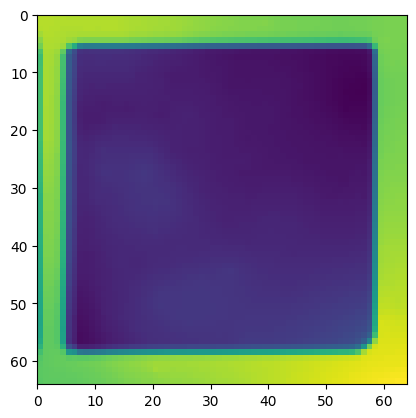

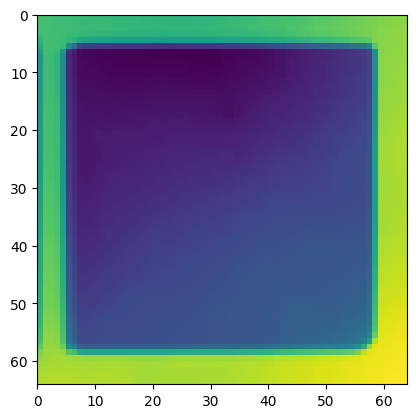

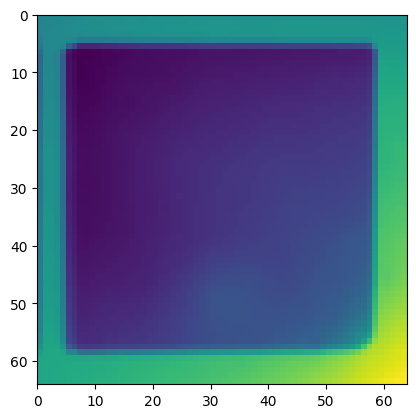

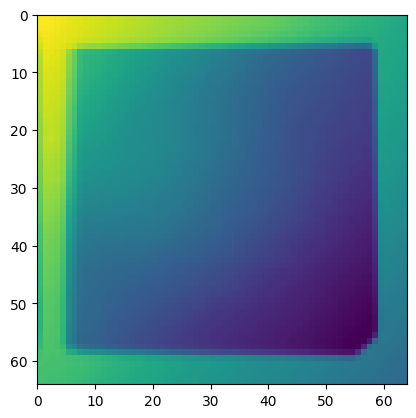

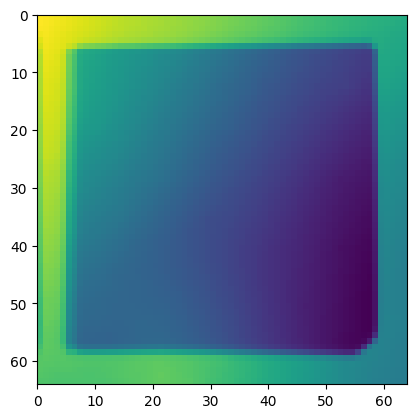

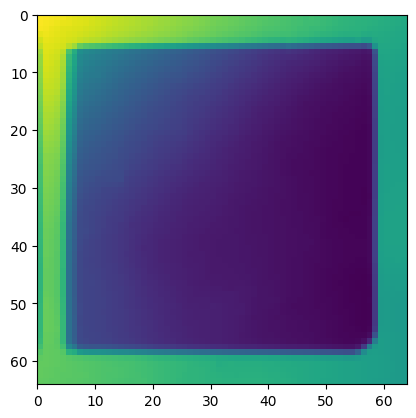

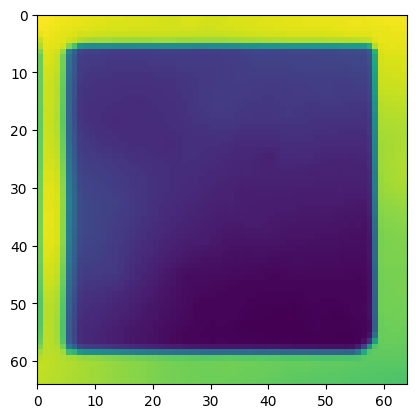

In [108]:
# generated image
import rasterio
from rasterio.plot import show

for index in range(20):
    fp = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/gene_hr" + str(index) + ".tif"
    img = rasterio.open(fp)
    show(img)

## Recover the original image


In [109]:
gene_images_tiles = []
for index in range(len(images_tiles)):
    fp = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/gene_hr" + str(index) + ".tif"
    img = rasterio.open(fp)
    gene_images_tiles.append(np.squeeze(img.read()))

In [110]:
# for i in gene_images_tiles:
#   print(i.shape)

In [111]:
len(added_col_or_arr_number)

14

In [112]:
operation_type

['columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows and columns added']

In [113]:
# This code recovers the original tiles' shape (because not all original images are 64x64)
for index_index, index in enumerate(tiles_index):
    if operation_type[index_index] == "columns added":
        n = added_col_or_arr_number[index_index]
        gene_images_tiles[index] = gene_images_tiles[index][:, n:]
    if operation_type[index_index] == "rows added":
        n = added_col_or_arr_number[index_index]
        gene_images_tiles[index] = gene_images_tiles[index][n:, :]
    if operation_type[index_index] == "rows and columns added":
        n_w, n_h = (
            added_col_or_arr_number_last_tile[0],
            added_col_or_arr_number_last_tile[1],
        )
        gene_images_tiles[-1] = gene_images_tiles[-1][:, n_w:]
        gene_images_tiles[-1] = gene_images_tiles[-1][n_h:, :]

In [114]:
# for i in gene_images_tiles:
#   print(i.shape)

In [115]:
path = "/home/s1300211/Documents/DEM-Super-Resolution/dataset/"
index = 0
for img in gene_images_tiles:
    tiff.imwrite(path + "/" + "original_hr_" + str(index) + ".tif", img)
    index += 1

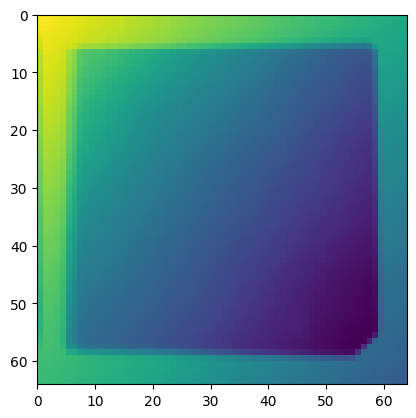

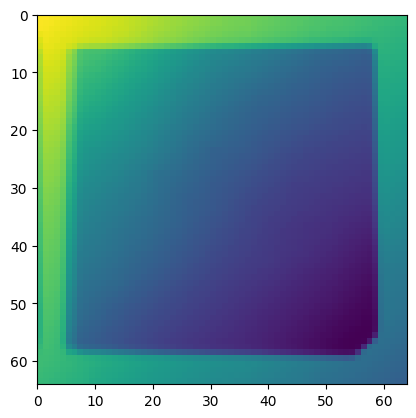

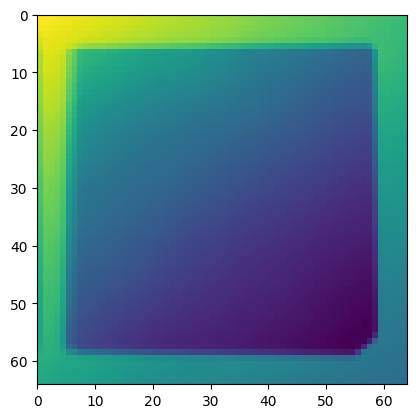

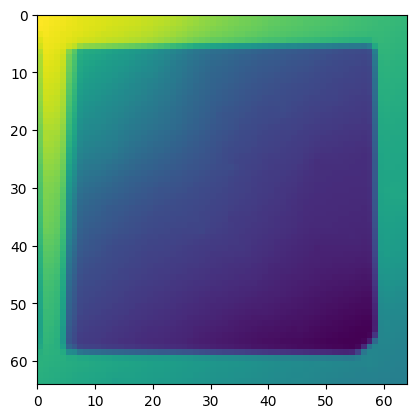

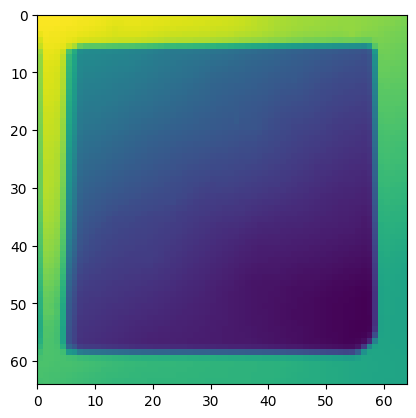

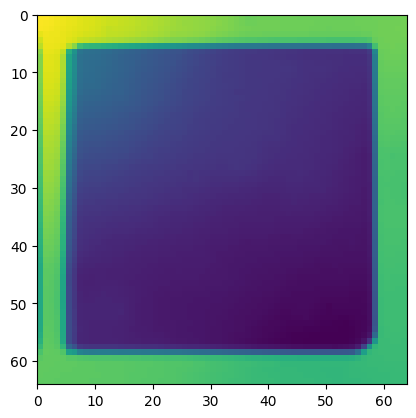

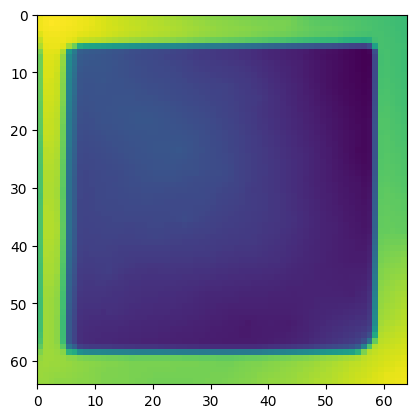

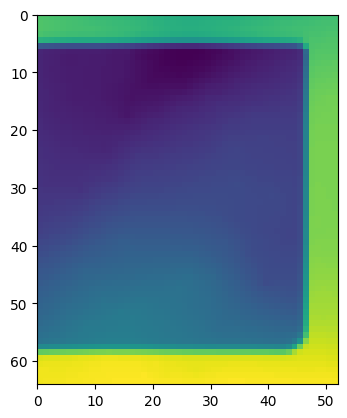

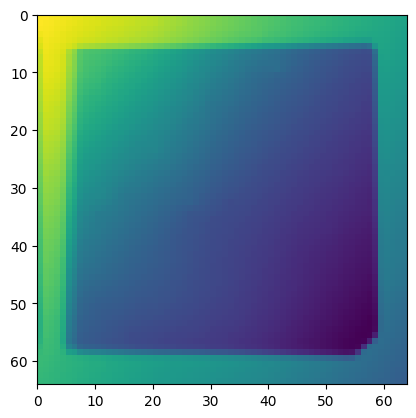

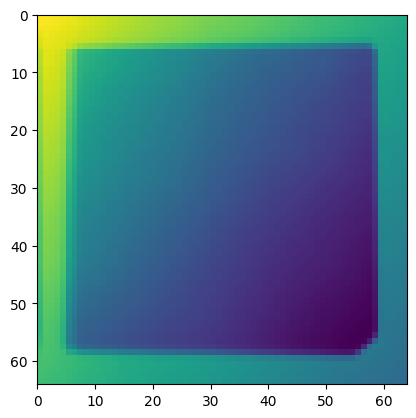

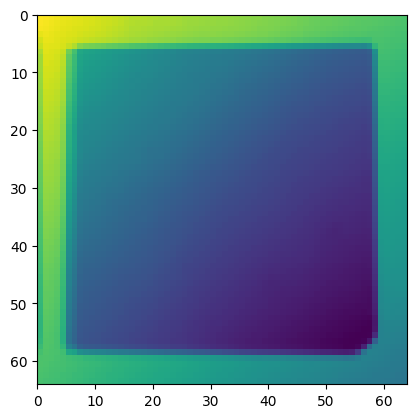

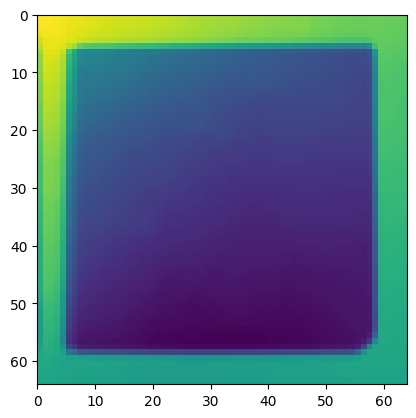

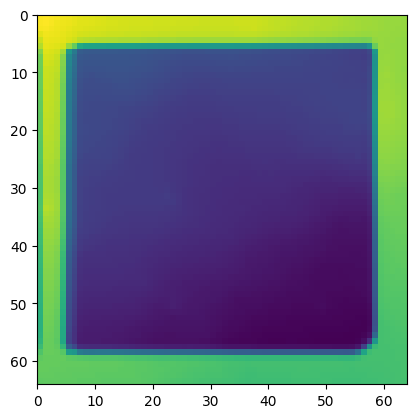

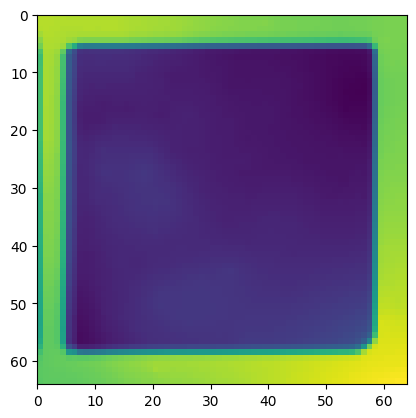

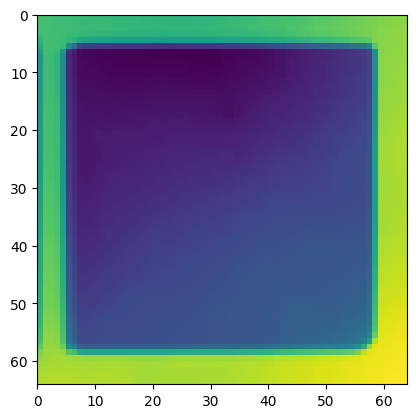

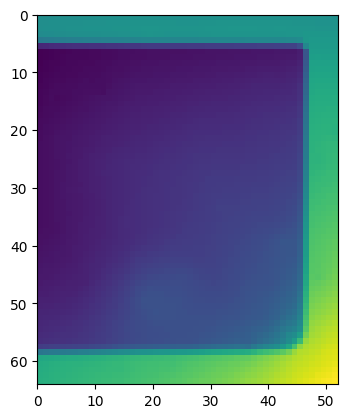

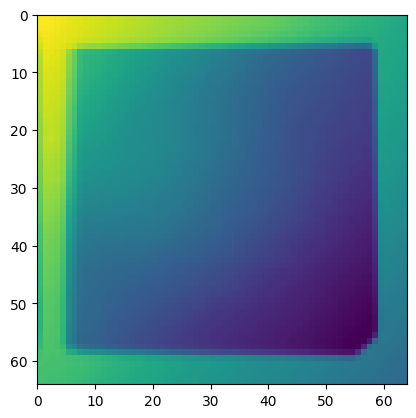

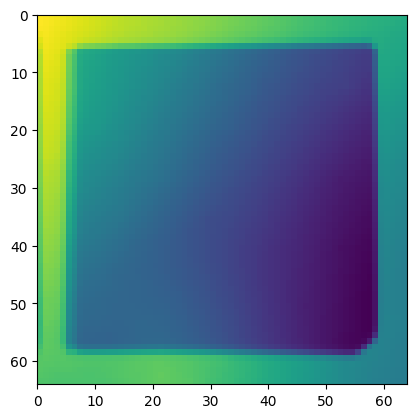

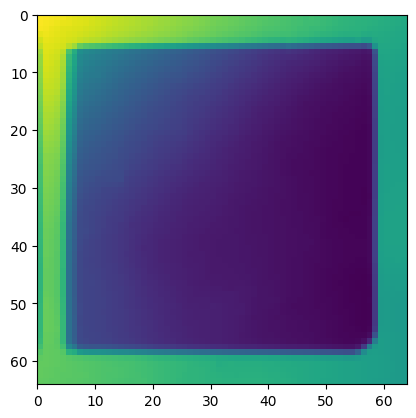

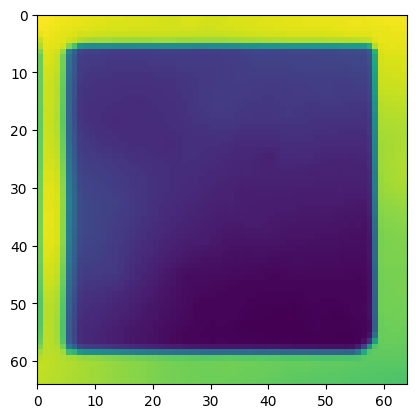

In [116]:
for index in range(20):
    fp = r"/home/s1300211/Documents/DEM-Super-Resolution/dataset/original_hr_" + str(index) + ".tif"
    img = rasterio.open(fp)
    show(img)

In [117]:
# function to recover the original image of (812 * 826)
H, W = img_lr.shape
if W % M == 0:
    n_w = int(W / M)
else:
    n_w = int(W / M) + 1
if H % N == 0:
    n_h = int(H / N)
else:
    n_h = int(H / N) + 1
reversed_array_h = []
a = 0
for i in range(n_h):
    split_arrays = []
    for j in range(a, n_w + a):
        split_arrays.append(gene_images_tiles[j])
    reversed_array = np.concatenate(
        split_arrays, axis=1
    )  # Concatenate the split arrays horizontally
    reversed_array_h.append(reversed_array)
    a = j + 1
reversed_array_final = np.concatenate(reversed_array_h, axis=0)
tiff.imwrite(path + "/gene_test_imge.tif", reversed_array_final)
print(reversed_array_final.shape)

(500, 500)


## Comparison: Original vs Super-Resolution DEM

超解像度処理前後のDEM画像を並べて表示して、改善を視覚的に確認します。


/tmp/ipykernel_1633529/2572014667.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.04, 1, 1])


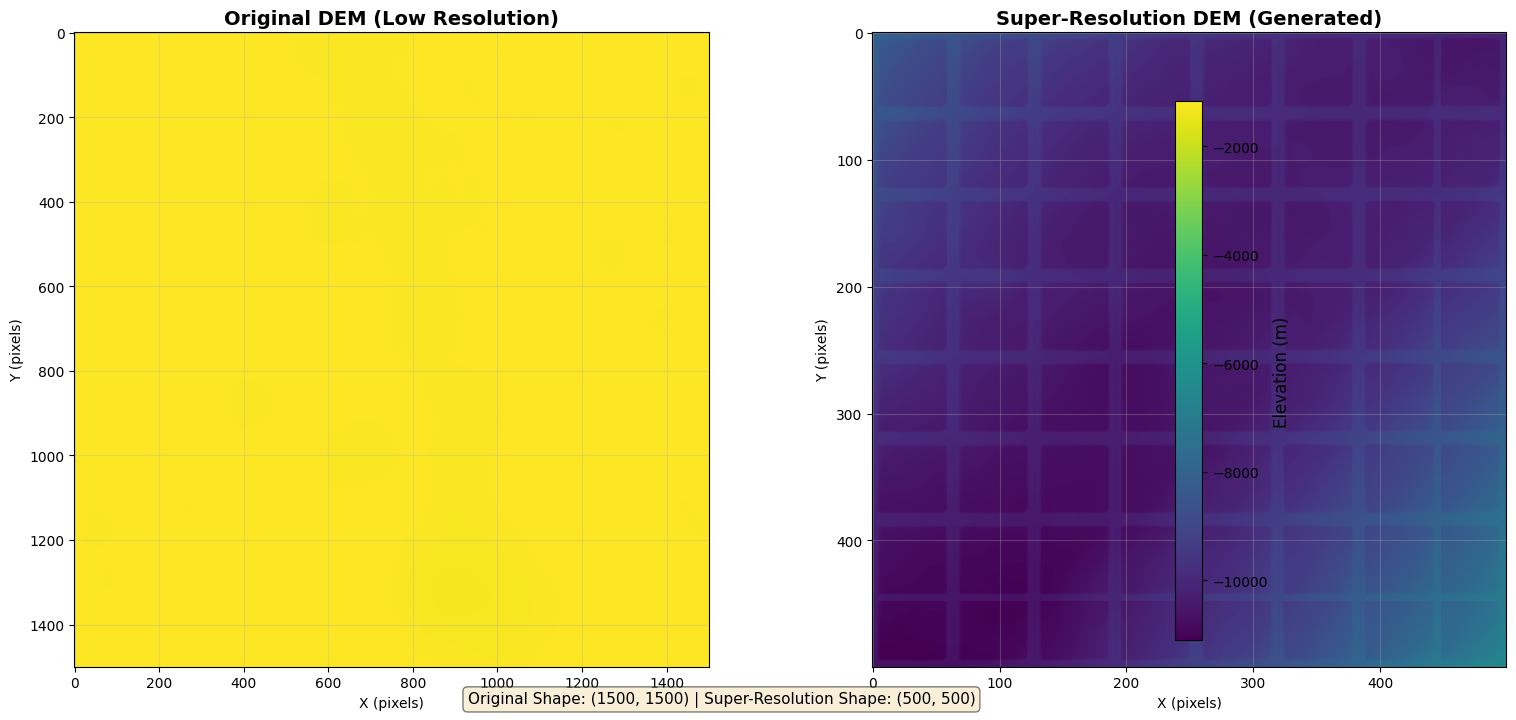

DEM Comparison Statistics

Original DEM:
  Shape: (1500, 1500)
  Min Elevation: -1310.47 m
  Max Elevation: -1176.59 m
  Mean Elevation: -1208.94 m
  Std Deviation: 16.86 m

Super-Resolution DEM:
  Shape: (500, 500)
  Min Elevation: -11106.67 m
  Max Elevation: -6509.97 m
  Mean Elevation: -9868.78 m
  Std Deviation: 782.13 m

Difference:
  Mean Difference: 8659.84 m


ValueError: operands could not be broadcast together with shapes (500,500) (1500,1500) 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import rasterio

# Load the original test DEM
test_dem_path = os.path.join(BASE_DIR, "datasets", "test", "center_tile.tif")
with rasterio.open(test_dem_path) as src:
    original_dem = src.read(1)

# Load the super-resolution DEM
with rasterio.open(path + "/gene_test_imge.tif") as src:
    sr_dem = src.read(1)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Normalize data for consistent coloring
vmin = min(original_dem.min(), sr_dem.min())
vmax = max(original_dem.max(), sr_dem.max())
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot original DEM
im1 = axes[0].imshow(original_dem, cmap='viridis', norm=norm)
axes[0].set_title('Original DEM (Input)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')
axes[0].grid(True, alpha=0.3)

# Plot super-resolution DEM
im2 = axes[1].imshow(sr_dem, cmap='viridis', norm=norm)
axes[1].set_title('Super-Resolution DEM (Generated)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Y (pixels)')
axes[1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap='viridis'), ax=axes, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)', fontsize=12)

# Add information text
fig.text(0.5, 0.02, f'Original Shape: {original_dem.shape} | Super-Resolution Shape: {sr_dem.shape}', 
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

# Print statistics
print("=" * 60)
print("DEM Comparison Statistics")
print("=" * 60)
print(f"\nOriginal DEM (Input from {test_dem_path}):")
print(f"  Shape: {original_dem.shape}")
print(f"  Min Elevation: {original_dem.min():.2f} m")
print(f"  Max Elevation: {original_dem.max():.2f} m")
print(f"  Mean Elevation: {original_dem.mean():.2f} m")
print(f"  Std Deviation: {original_dem.std():.2f} m")

print(f"\nSuper-Resolution DEM:")
print(f"  Shape: {sr_dem.shape}")
print(f"  Min Elevation: {sr_dem.min():.2f} m")
print(f"  Max Elevation: {sr_dem.max():.2f} m")
print(f"  Mean Elevation: {sr_dem.mean():.2f} m")
print(f"  Std Deviation: {sr_dem.std():.2f} m")

print(f"\nDifference:")
print(f"  Mean Difference: {abs(sr_dem.mean() - original_dem.mean()):.2f} m")
print(f"  RMSE: {np.sqrt(np.mean((sr_dem - original_dem) ** 2)):.2f} m")
print("=" * 60)
